# Описание проекта 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. Руководство хочет, чтобы в приложении можно было рассчитать рыночную стоимость автомобиля. 

Наша задача построить модель, которая умеет определять рыночную стоимость автомобиля. В нашем распоряжении данные о технических характеристиках, комлпектации и ценах других автомобилей. 

Критерии, которые важны заказчику:

- качество предсказания
- время обучения модели
- время предсказания модели

  
Примечания:

- Метрикой будем использовать RMSE по требованию заказчика
- Значение метрики RMSE должно быть меньше 2500

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import shap
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from optuna.integration import OptunaSearchCV
from optuna.distributions import ( 
    IntDistribution, 
    CategoricalDistribution,
    FloatDistribution
)

from sklearn.metrics import root_mean_squared_error

import timeit


import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
try:
    autos = pd.read_csv('autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные были успешно загружены. Сразу видно, что в данных имеются пропуски.

# Предобработка данных

Нужно разобраться с дубликатами и пропусками в данных.

Создадим копию датасета для всех наших преобразований.

In [6]:
df = autos.copy()

Посмотрим дубликаты.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [9]:
df = df.drop_duplicates()
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


С явными дубликатами разобрались, посмотрим не явные.

У нас есть следующие данные и их типы:


- DateCrawled — дата скачивания анкеты из базы - дата и время
- Price - цена - количественный
- VehicleType — тип автомобильного кузова - категориальный
- RegistrationYear — год регистрации автомобиля - дата и время
- Gearbox — тип коробки передач - категориальный
- Power — мощность (л. с.) - количественный
- Model — модель автомобиля - категориальный
- Kilometer — пробег (км) - количественный
- RegistrationMonth — месяц регистрации автомобиля - категориальный
- FuelType — тип топлива - категориальный
- Brand — марка автомобиля - категориальный
- Repaired — была машина в ремонте или нет - категориальный
- DateCreated — дата создания анкеты - дата и время
- NumberOfPictures — количество фотографий автомобиля - количественный
- PostalCode — почтовый индекс владельца анкеты (пользователя) - категориальный
- LastSeen — дата последней активности пользователя - дата и время

Преобразуем типы данных с датой и временем из object в дату и время. Затем в типах данных object проверим наличие не явных дубликатов.

In [10]:
df['DateCrawled'] = pd.to_datetime(
    df['DateCrawled'], format='%Y-%m-%d %H:%M:%S'
)

df['DateCreated'] = pd.to_datetime(
    df['DateCreated'], format='%Y-%m-%d %H:%M:%S'
)

df['LastSeen'] = pd.to_datetime(
    df['LastSeen'], format='%Y-%m-%d %H:%M:%S'
)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

In [12]:
for name in df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).select_dtypes(exclude=np.number).columns:
    print(name, df[name].unique())

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox ['manual' 'auto' nan]
Model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

В VehicleType, Model, Brand, Repaired всё в порядке.

В FuelType petrol и gasoline несут под собой одно и то же топливо - бензин. Заменим gasoline на petrol.

In [13]:
df['FuelType'] = df['FuelType'].replace({'gasoline': 'petrol'})
df['FuelType'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Теперь разберёмся с пропусками.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

Опишем, что делать с каждым столбцом:

- DateCrawled — пропуски отсутствуют
- Price - пропуски отсутствуют
- VehicleType — здесь пропуски не получится устранить, можно либо поставить самое популярное значение, либо во всех пропусках поставить other. Воспользуемся первым способом
- RegistrationYear — пропуски отсутствуют
- Gearbox — поставим самое популярное значение
- Power — пропуски отсутствуют
- Model — вместо пропусков поставим other
- Kilometer — пропуски отсутствуют
- RegistrationMonth — пропуски отсутствуют
- FuelType — можно так же либо other, либо самое популярное значение, лучше поставим other, так как пропусков не так много
- Brand — пропуски отсутствуют
- Repaired — здесь поставим no, так как, если нет данных, что машина была в ремонте, вероятно, она там не была
- DateCreated — пропуски отсутствуют
- NumberOfPictures — пропуски отсутствуют
- PostalCode — пропуски отсутствуют
- LastSeen — пропуски отсутствуют

Уберём пропуски.

In [15]:
df['VehicleType'].fillna(df['VehicleType'].mode().iloc[0], inplace=True)
df['Gearbox'].fillna(df['Gearbox'].mode().iloc[0], inplace=True)
df['Model'].fillna('other', inplace=True)
df['FuelType'].fillna('other', inplace=True)
df['Repaired'].fillna('no', inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

Пропуски и дубликаты устранены. Предобработали данные, было много столбцов с пропусками и дубликатами. Для каждого столбца пришлось подбирать отдельную идею удаления пропусков. Из интересного, чтобы найти дубликаты нужно было понять, что gasoline и petrol это одно и то же, просто одно название используется в США, другое в Европе. Одно пришлось заменить на другое. 

# Исследовательский анализ данных

In [17]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

Все типы данных соответсвуют заявленным, кроме данных с датой. 

Рассмотрим сначала количественные переменные, затем категориальные.


## Количественные

Сначала рассмотрим гистограммы для всех признаков.

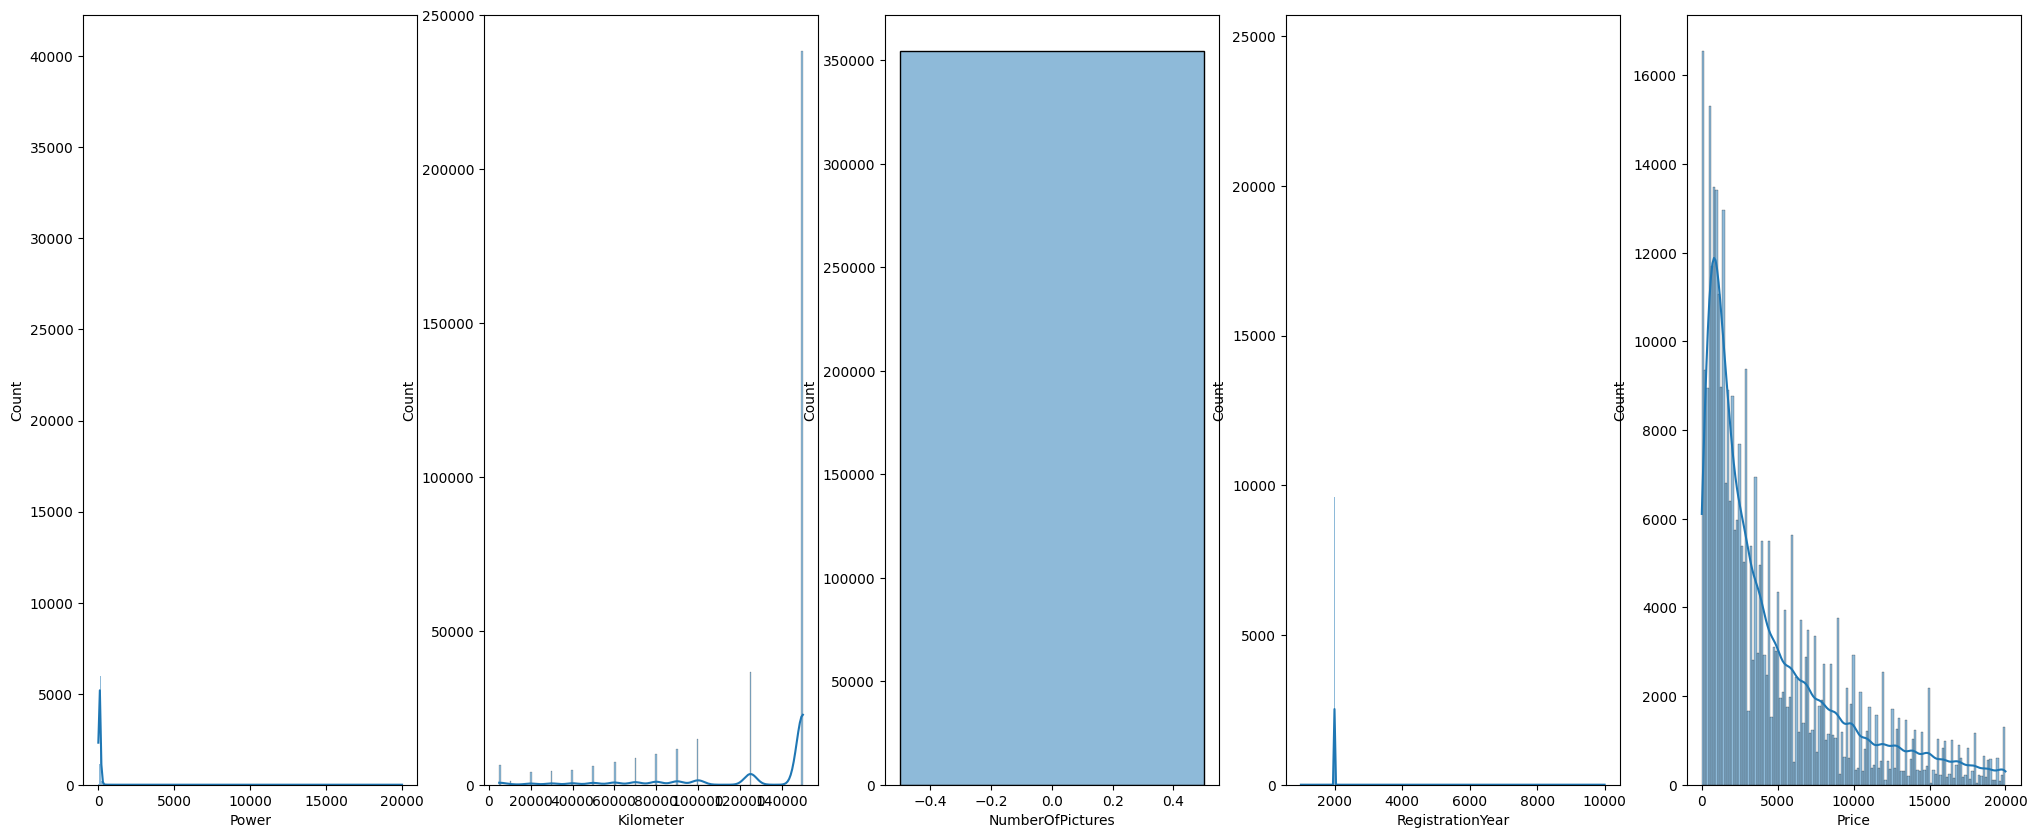

In [19]:
col_names =  ['Power', 'Kilometer', 'NumberOfPictures', 'RegistrationYear', 'Price']
fig, axs = plt.subplots(nrows=1, ncols=len(col_names), figsize=(25,10))

for i, name in enumerate(col_names):
    sns.histplot(data=df[col_names].loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel(name)

plt.show()

В данных наблюдаются выбросы, рассмотрим каждый столбец по отдельности.

### Power

Разным автомобилям присущи разные мощности двигателя, но обычно мощности двигателя от 70 до 300, посмотрим признак.

In [20]:
df['Power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Посмотрим строки, где мощность равна 0.

In [21]:
len(df[df['Power']==0])

40225

In [22]:
df[df['Power']==0].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,manual,0,ka,5000,0,petrol,ford,no,2016-03-11,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,sedan,2016,manual,0,kangoo,150000,1,petrol,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,sedan,1990,manual,0,corsa,150000,1,petrol,opel,no,2016-03-26,0,56412,2016-03-27 17:43:34


Мощность не может быть равно 0, поэтому заменим их на средние значения по выборке.

In [23]:
df['Power'] = df['Power'].replace(0, df['Power'].mean())

In [24]:
len(df[df['Power']==0])

0

Посмотрим ящик с усами.

Text(0, 0.5, 'Value')

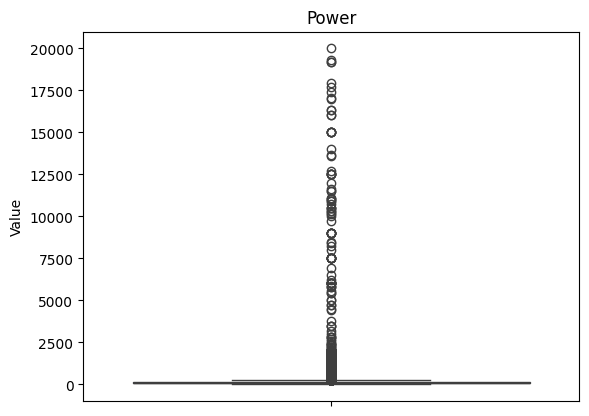

In [25]:
sns.boxplot(df['Power']);
plt.title('Power')
plt.ylabel('Value')

Посмотрим, какие значения boxplot посчитал выбросами и сколько их.

In [26]:
print('q1:', df['Power'].describe()['25%'])
print('q3:', df['Power'].describe()['75%'])
print('Межквартильный размах:', df['Power'].describe()['75%'] - df['Power'].describe()['25%'])
print('Нижняя граница:', max(df['Power'].describe()['min'], df['Power'].describe()['25%'] - 1.5 * (df['Power'].describe()['75%'] - df['Power'].describe()['25%'])))
print('Верхняя граница:', min(df['Power'].describe()['max'], df['Power'].describe()['75%'] + 1.5 * (df['Power'].describe()['75%'] - df['Power'].describe()['25%'])))
print('Пять межквартильных расстояний нижняя:', max(df['Power'].describe()['min'], df['Power'].describe()['25%'] - 5 * (df['Power'].describe()['75%'] - df['Power'].describe()['25%'])))
print('Пять межквартильных расстояний верхняя:', min(df['Power'].describe()['max'], df['Power'].describe()['75%'] + 5 * (df['Power'].describe()['75%'] - df['Power'].describe()['25%'])))

q1: 84.0
q3: 143.0
Межквартильный размах: 59.0
Нижняя граница: 1.0
Верхняя граница: 231.5
Пять межквартильных расстояний нижняя: 1.0
Пять межквартильных расстояний верхняя: 438.0


Дополнительно вывели +5 и -5 межквартильных расстояния, так как 231 это не такая высокая граница и есть много машин с большей мощностью двигателя.

In [27]:
len(df[df['Power']>438])

641

Можем взять 5 межквартильных расстояний как предел и удалить, потому что мало есть машин с л.с. больше, чем 438. Если среди них есть машины с настоящей мощностью больше 438, то, скорее всего, они только помешают обучению для других машин, поэтому их тоже можно удалить вместе с выбросами.

In [28]:
df = df[df['Power']<=438]
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,110.093816,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.000000,other,125000,5,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.000000,grand,125000,8,petrol,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.000000,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.000000,fabia,90000,7,petrol,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [29]:
df['Power'].describe()

count    353724.000000
mean        118.718820
std          49.859949
min           1.000000
25%          84.000000
50%         110.093816
75%         141.000000
max         435.000000
Name: Power, dtype: float64

Посмотрим графики снова.

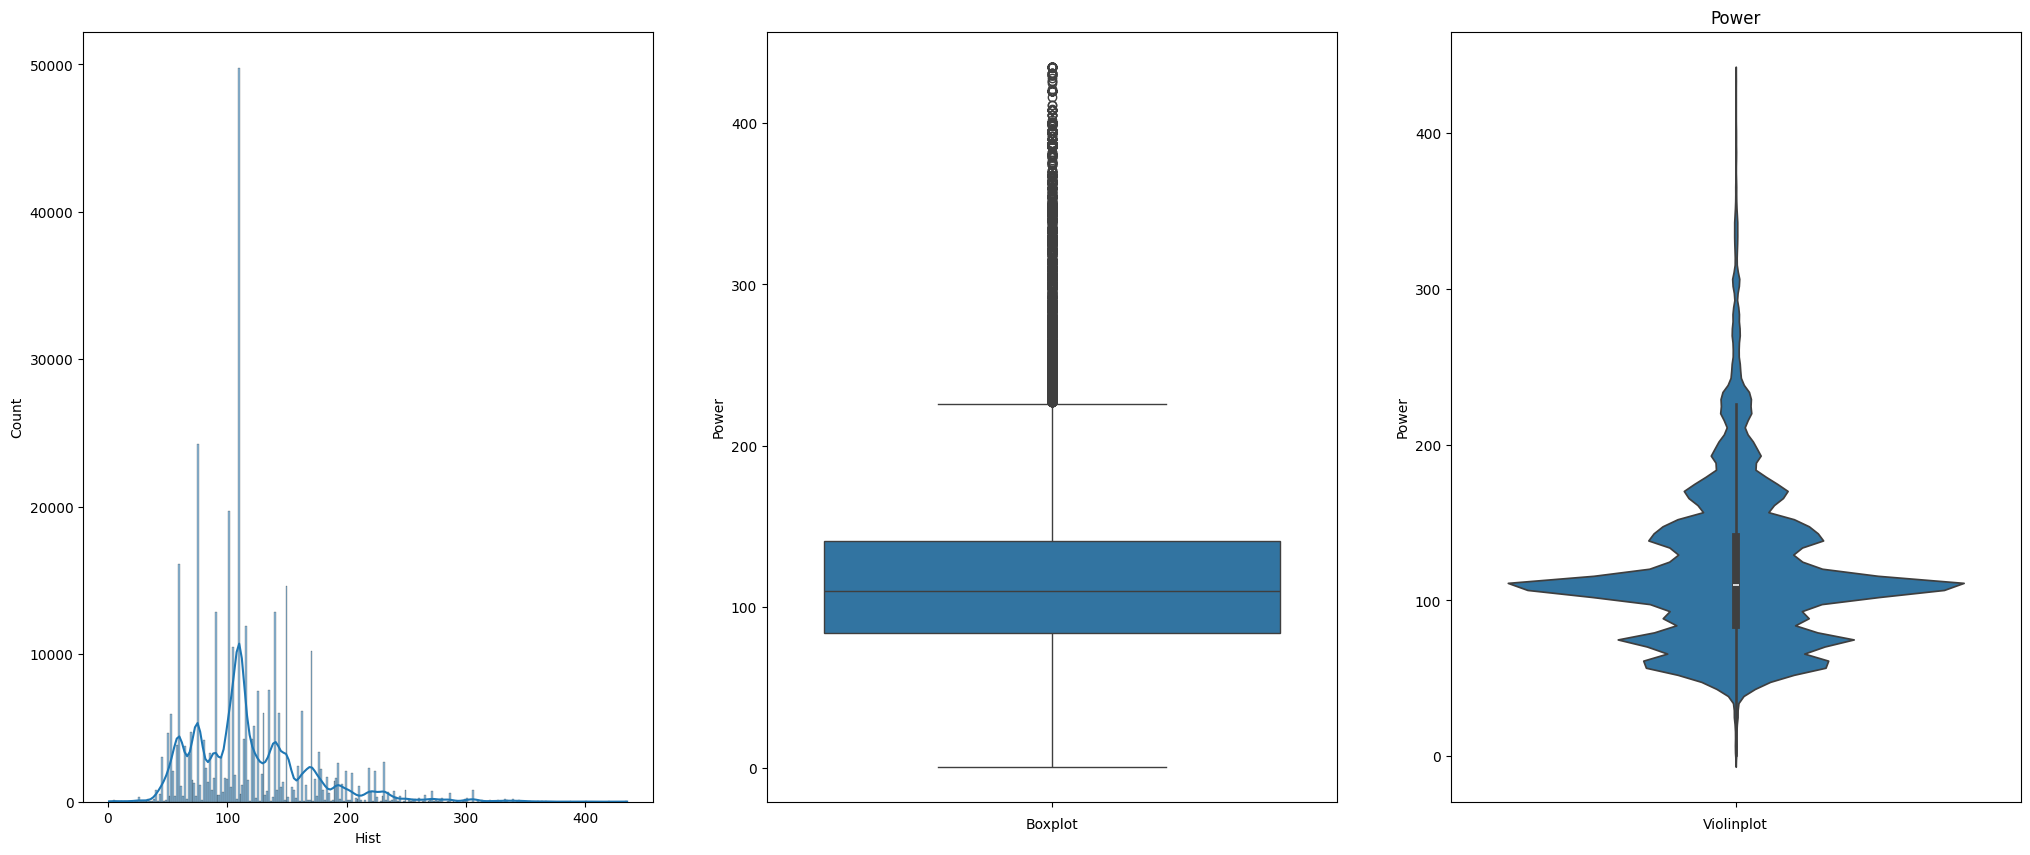

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

sns.histplot(data=df['Power'], ax=axs[0], kde=True)
axs[0].set_xlabel("Hist")

sns.boxplot(data=df['Power'], ax=axs[1])
axs[1].set_xlabel('Boxplot')

sns.violinplot(data=df['Power'], ax=axs[2])
axs[2].set_xlabel('Violinplot')

plt.title('Power')
plt.show()

Были удалены выбросы для удобства работы с данными и улучшения работы модели. Как видим, мощности двигателя по большей части находятся от 84 до 141, но есть и больше. В Power были огромные выбросы и много нулевых значений. Нулевые заменили на средние. Выбросы больше, чем 438 удалили (438 - это медиана +5 межквартильных расстояния, обычно берут 1.5, но было взято 5, чтобы не удалять слишком много значений). Были построены гистограмма, boxplot и violinplot.

### Kilometer

In [31]:
df['Kilometer'].describe()

count    353724.000000
mean     128218.017437
std       37891.053708
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Явно есть много значений с пробегом 150000, нужно их проверить.

In [32]:
len(df[df['Kilometer']==150000])

237779

Вероятно, на сайте максимальное значение - это 1500 000 в пробеге, либо при скачивании данных произошла ошибка и многим значеням попало 150 000, либо все, что больше 150 000 стали 150 000. Можно сделать эту переменную категориальной со значениями больше 150 000 и меньше 150 000.

In [33]:
df['Kilometer'] = df['Kilometer'] == 150000

In [34]:
df['Kilometer'].head()

0     True
1    False
2    False
3     True
4    False
Name: Kilometer, dtype: bool

In [35]:
df = df.rename(columns={'Kilometer': 'Great150'})
col_names =  ['Power', 'NumberOfPictures', 'RegistrationYear']

Рассмотрим данную переменную далее с категориальными.

### NumberOfPictures

In [36]:
df['NumberOfPictures'].describe()

count    353724.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

In [37]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

В данном столбце вовсе одни нули, его нужно удалить.

In [38]:
df.drop('NumberOfPictures', axis=1, inplace=True)
col_names =  ['Power', 'RegistrationYear']

### RegistrationYear

In [39]:
df['RegistrationYear'].describe()

count    353724.000000
mean       2004.232076
std          89.945073
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Явно имеются выбросы, посмотрим boxplot.

Text(0, 0.5, 'Value')

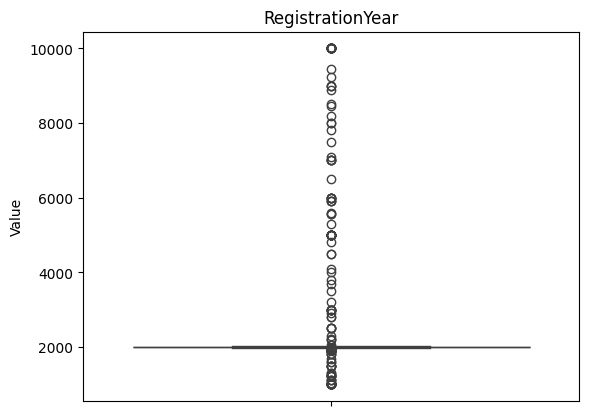

In [40]:
sns.boxplot(df['RegistrationYear']);
plt.title('RegistrationYear')
plt.ylabel('Value')

In [41]:
len(df[df['RegistrationYear']>2024])

101

In [42]:
len(df[df['RegistrationYear']<1980])

3433

Удалим все машины с годом больше, чем 2024 и меньше, чем 1980. Больше 2024 удалим, так как это явные выбросы, меньшие 1980 - так как среди них тоже могут выбросы, кроме того, цену старых машин тяжело предсказывать в силу того, что они могут иметь раритетность.

In [43]:
df = df[(df['RegistrationYear']>=1980) & (df['RegistrationYear']<=2024)]

Посмотрим теперь все графики.

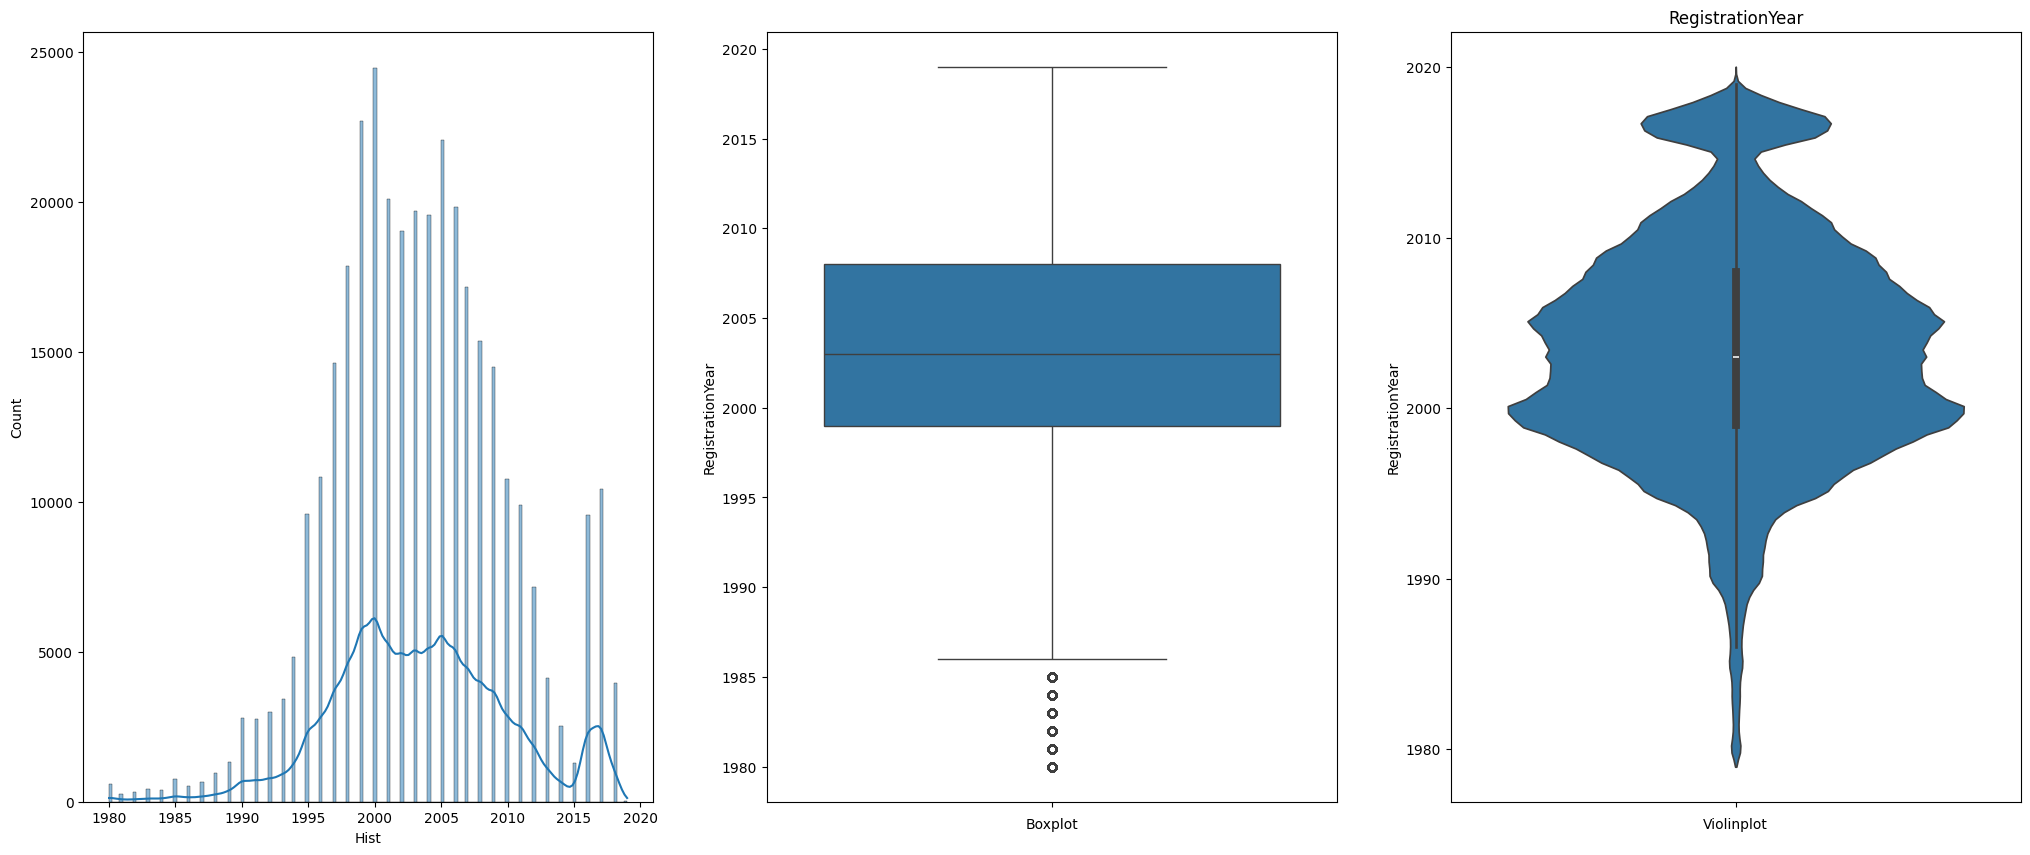

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

sns.histplot(data=df['RegistrationYear'], ax=axs[0], kde=True)
axs[0].set_xlabel("Hist")

sns.boxplot(data=df['RegistrationYear'], ax=axs[1])
axs[1].set_xlabel('Boxplot')

sns.violinplot(data=df['RegistrationYear'], ax=axs[2])
axs[2].set_xlabel('Violinplot')

plt.title('RegistrationYear')
plt.show()

Как видно, большинство машин зарегистрировано в промежуток с 1998 до 2010. Есть выброс в 2015 по 2020. 

### Price

In [45]:
df['Price'].describe()

count    350190.000000
mean       4389.490014
std        4488.664567
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6300.000000
max       20000.000000
Name: Price, dtype: float64

Посмотрим значения с ценой меньше 350.

In [46]:
len(df[df['Price']<350])

25772

Эти данные придется удалить, так как маленькая цена может всё испортить. Возможно, люди хотели отдать свою машину просто так, но машины, которые раздают, не помогут нам улучшить предсказание.

In [47]:
df = df[df['Price']>350]

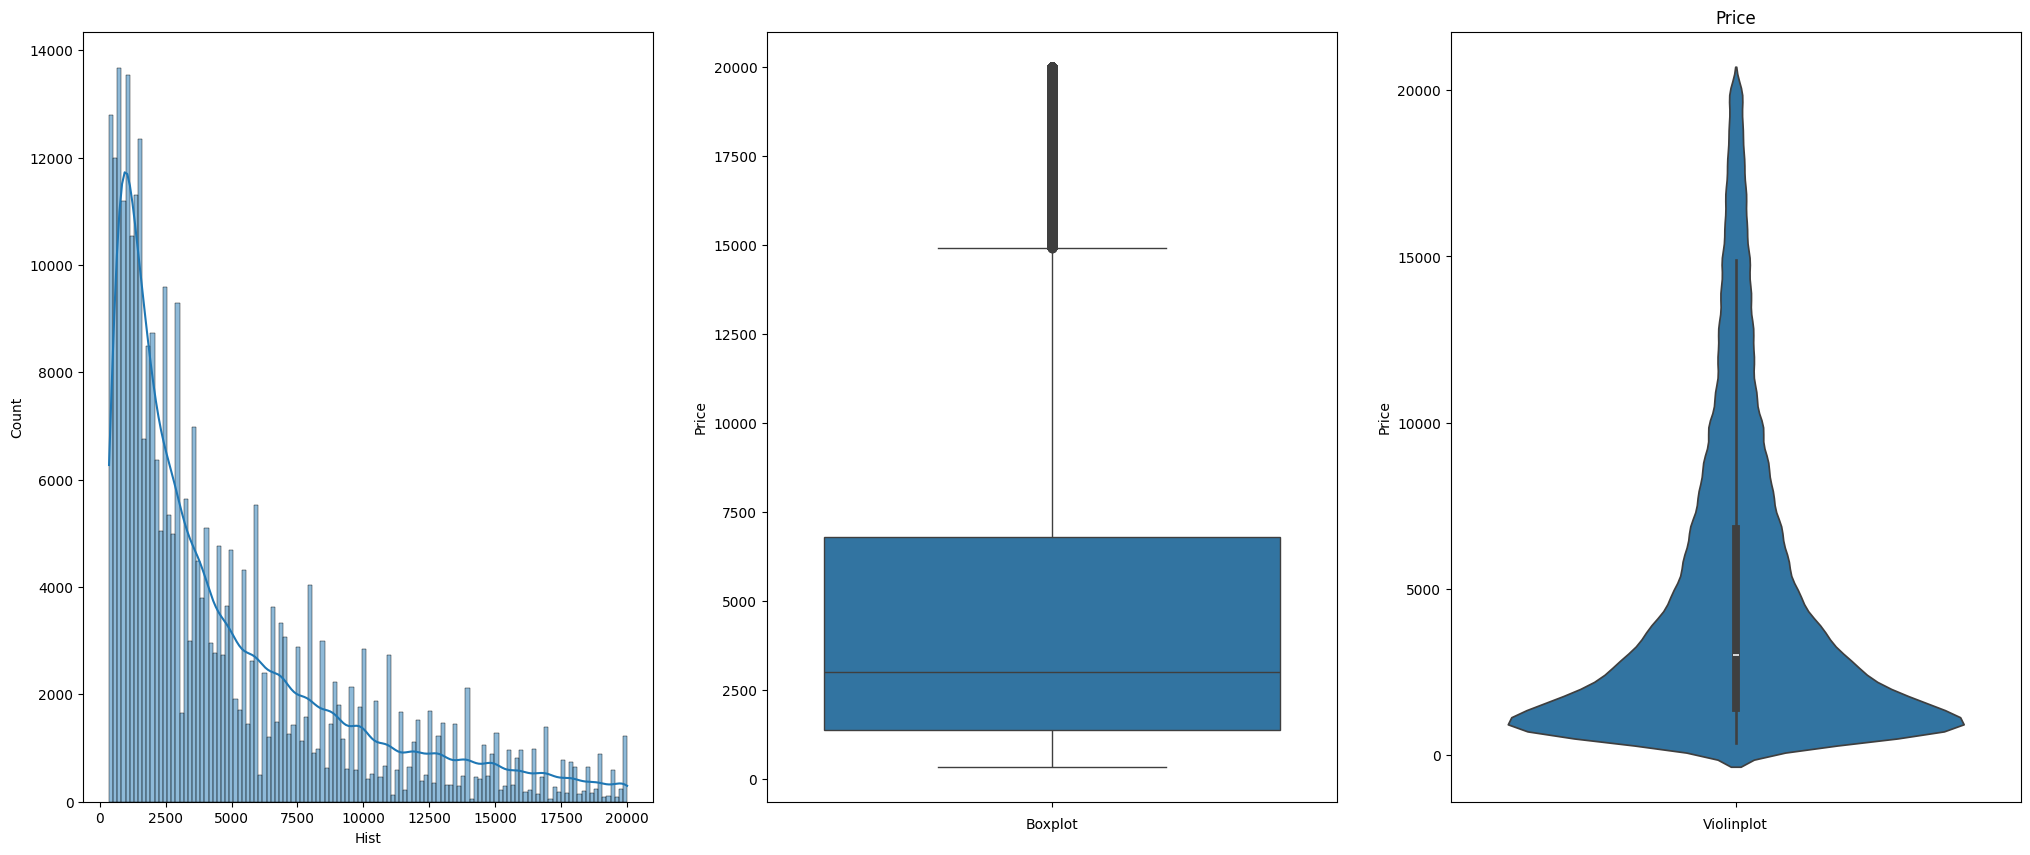

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

sns.histplot(data=df['Price'], ax=axs[0], kde=True)
axs[0].set_xlabel("Hist")

sns.boxplot(data=df['Price'], ax=axs[1])
axs[1].set_xlabel('Boxplot')

sns.violinplot(data=df['Price'], ax=axs[2])
axs[2].set_xlabel('Violinplot')

plt.title('Price')
plt.show()

In [49]:
df['Price'].describe()

count    321912.000000
mean       4763.188567
std        4493.000028
min         355.000000
25%        1399.000000
50%        3000.000000
75%        6800.000000
max       20000.000000
Name: Price, dtype: float64

Как видим, большинство машин находятся в диапазоне от 1400 до 6800 евро. Есть ценники, доходящие вплоть до 20 000 евро.

## Категориальные 

Выведем гистограммы для категориальных переменных.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321912 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        321912 non-null  datetime64[ns]
 1   Price              321912 non-null  int64         
 2   VehicleType        321912 non-null  object        
 3   RegistrationYear   321912 non-null  int64         
 4   Gearbox            321912 non-null  object        
 5   Power              321912 non-null  float64       
 6   Model              321912 non-null  object        
 7   Great150           321912 non-null  bool          
 8   RegistrationMonth  321912 non-null  int64         
 9   FuelType           321912 non-null  object        
 10  Brand              321912 non-null  object        
 11  Repaired           321912 non-null  object        
 12  DateCreated        321912 non-null  datetime64[ns]
 13  PostalCode         321912 non-null  int64        

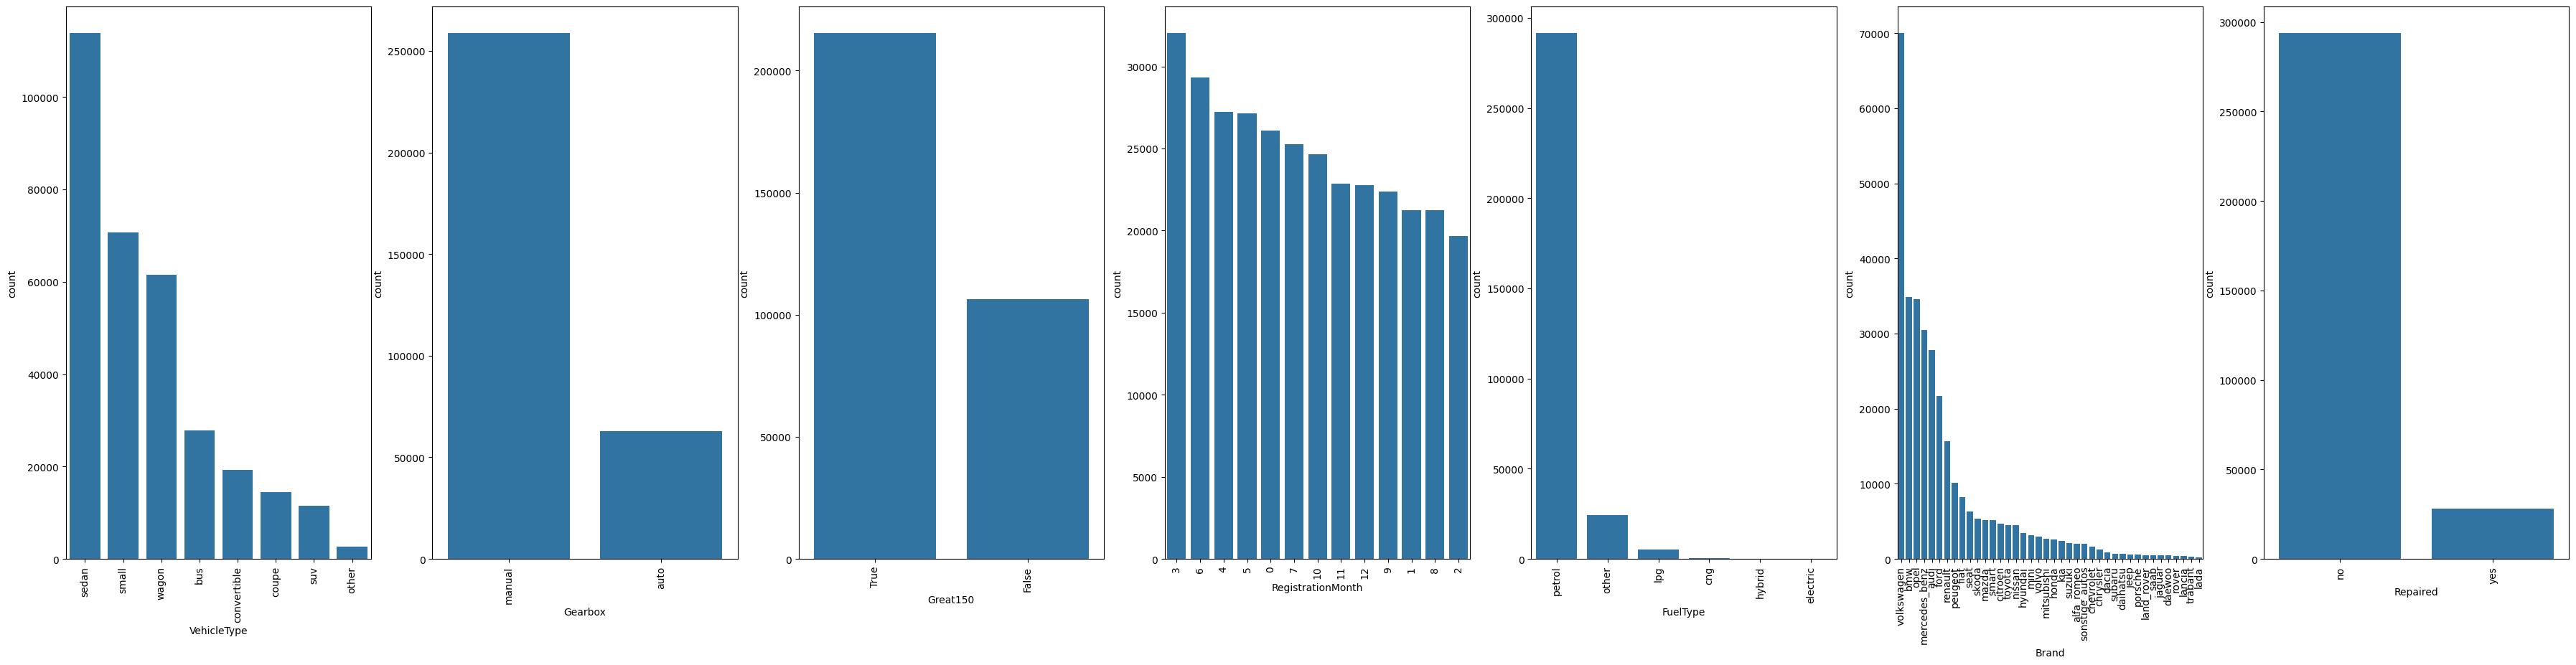

In [51]:
cat_names = ['VehicleType', 'Gearbox', 'Great150', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

fig, axs = plt.subplots(nrows=1, ncols=len(cat_names), figsize=(45, 10))

for i, name in enumerate(cat_names):
    sns.countplot(data=df, x=name, ax=axs[i], order=df[name].value_counts().index)
    axs[i].set_xlabel(name)
    axs[i].tick_params(axis='x', rotation=90)
plt.show()


Все данные по категориальным переменным видны на графиках. 

В VehicleType видно, что самые популярные машины на продажу - это sedan - больше 120 000.

В Gearbox самой популярной коробкой является механика, автоматическая меньше в 5 раз.

Большинство машин имеет пробег более 150 000, в два раза меньше имеет меньше 150 000.

В RegistrationMonth видим, что самым популярным является месяц 0, вероятно, это машины, у которых неизвестна дата регистрации.

В FuelType самым популярным топливом является бензин.

В брендах самым популярным является volkswagen, за ним opel, которого в два раза меньше. Остальных ещё меньше.

В Repaired намного больше не чиненых машин.

## Дата и время

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321912 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        321912 non-null  datetime64[ns]
 1   Price              321912 non-null  int64         
 2   VehicleType        321912 non-null  object        
 3   RegistrationYear   321912 non-null  int64         
 4   Gearbox            321912 non-null  object        
 5   Power              321912 non-null  float64       
 6   Model              321912 non-null  object        
 7   Great150           321912 non-null  bool          
 8   RegistrationMonth  321912 non-null  int64         
 9   FuelType           321912 non-null  object        
 10  Brand              321912 non-null  object        
 11  Repaired           321912 non-null  object        
 12  DateCreated        321912 non-null  datetime64[ns]
 13  PostalCode         321912 non-null  int64        

### DateCrawled

In [53]:
df['DateCrawled'].describe()

count                           321912
mean     2016-03-21 12:59:23.875987968
min                2016-03-05 14:06:23
25%      2016-03-13 11:38:28.249999872
50%                2016-03-21 17:51:36
75%      2016-03-29 14:46:22.249999872
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Даты идут от 2016-03-05 до 2016-04-07. Выгрузка данных проходила на протяжении месяца.

### DateCreated

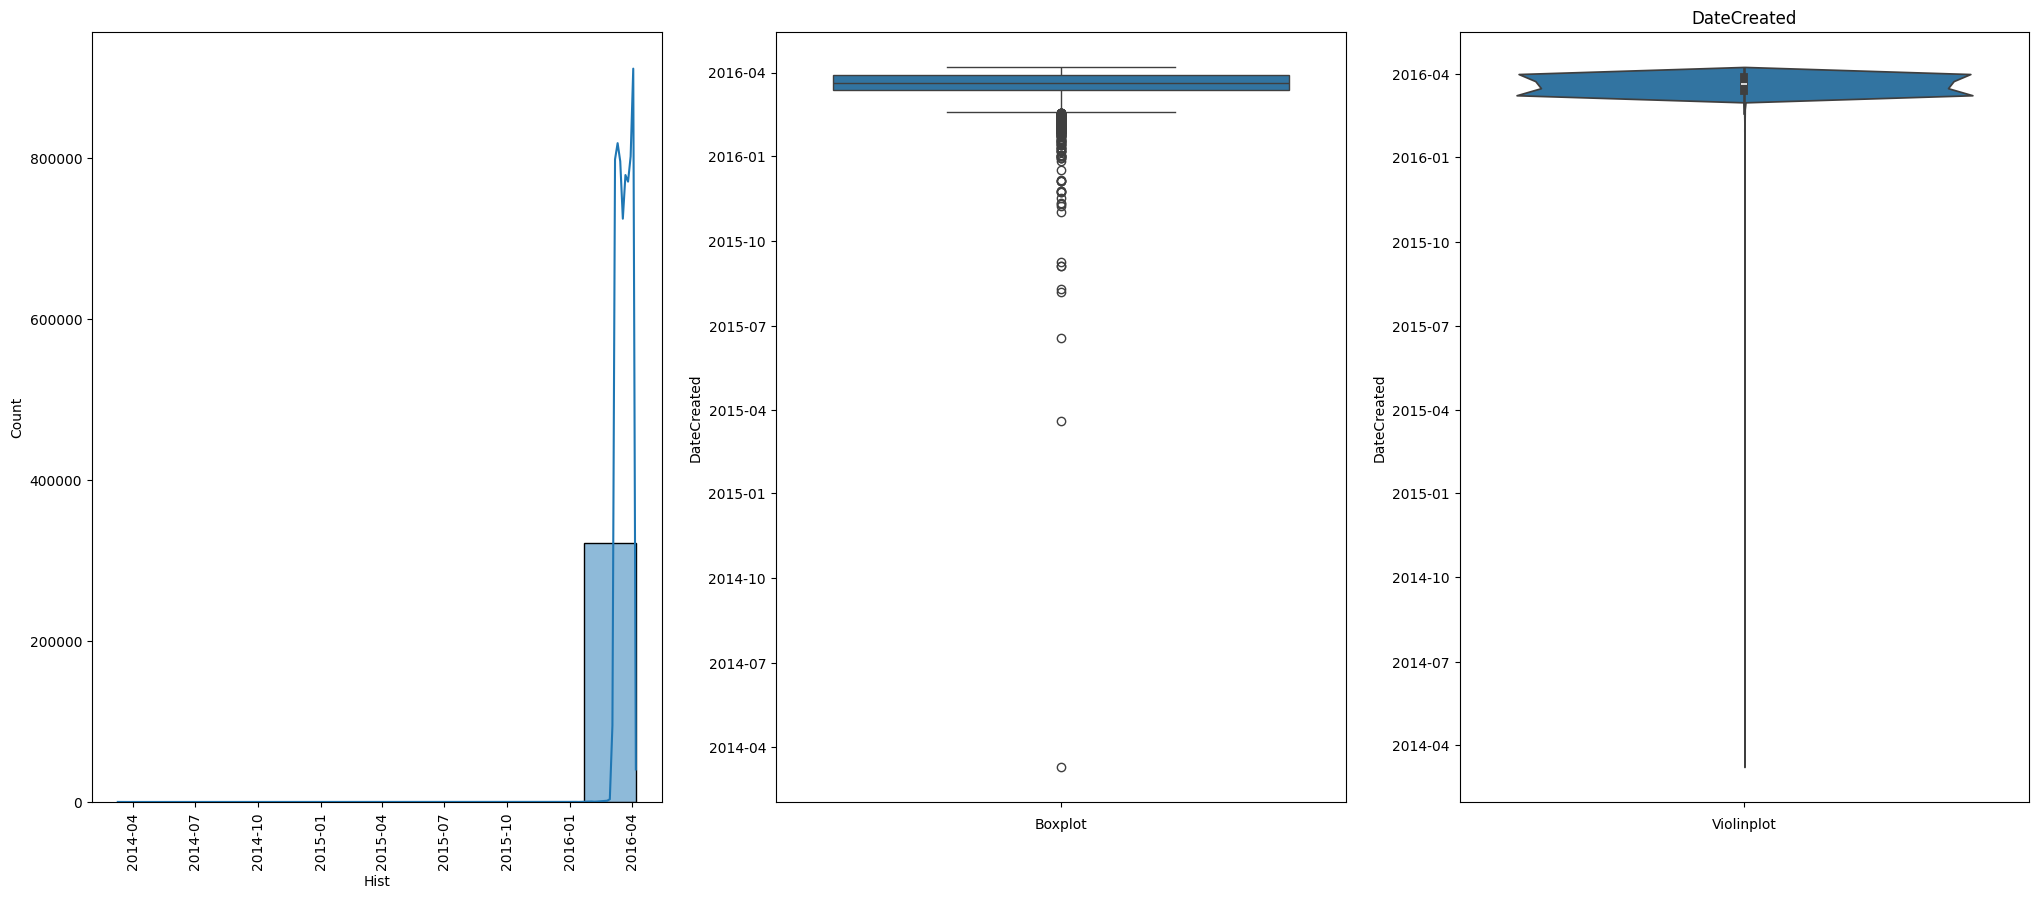

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

sns.histplot(data=df['DateCreated'], ax=axs[0], kde=True, bins=10)
axs[0].set_xlabel("Hist")
axs[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=df['DateCreated'], ax=axs[1])
axs[1].set_xlabel('Boxplot')

sns.violinplot(data=df['DateCreated'], ax=axs[2])
axs[2].set_xlabel('Violinplot')

plt.title('DateCreated')
plt.show()

Имеются даты создания анкет вплоть до 2014 года. Возможно, это дорогие машины, которые долго висят, либо не понятные объявления, посмотрим их.

In [55]:
df[df['DateCreated']<'2016-01-01']

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Great150,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200.000000,other,True,0,petrol,chevrolet,no,2015-03-20,24558,2016-04-07 03:45:01
9972,2016-03-05 17:53:53,3490,sedan,2006,manual,88.000000,clio,True,3,petrol,renault,no,2015-11-02,40880,2016-03-17 15:46:57
29712,2016-03-28 13:31:25,6950,sedan,2004,auto,150.000000,a3,False,1,petrol,audi,no,2015-12-06,61389,2016-04-06 14:16:09
60168,2016-03-05 20:42:38,5999,sedan,1997,auto,197.000000,c_klasse,True,9,petrol,mercedes_benz,no,2015-11-17,28816,2016-04-06 05:46:03
61207,2016-03-16 11:48:06,8999,sedan,2005,manual,110.093816,147,False,0,petrol,alfa_romeo,no,2014-03-10,79669,2016-04-07 04:46:24
75598,2016-03-14 08:43:53,600,small,2005,manual,54.000000,polo,True,1,petrol,volkswagen,yes,2015-09-04,72669,2016-03-15 14:16:58
75684,2016-03-14 18:44:30,5400,small,2009,manual,44.000000,ypsilon,False,9,petrol,lancia,no,2015-11-12,53119,2016-04-06 03:16:57
76459,2016-03-05 15:50:46,7500,sedan,2002,auto,333.000000,7er,True,9,lpg,bmw,no,2015-12-27,46117,2016-03-27 22:15:37
77378,2016-03-14 08:27:52,7999,sedan,2013,manual,75.000000,mii,False,6,petrol,seat,no,2015-11-24,60437,2016-04-05 22:47:33
85505,2016-03-14 01:41:25,900,sedan,1997,auto,115.000000,impreza,True,4,petrol,subaru,no,2015-12-05,2943,2016-03-22 23:16:25


Возможно, это машины с не очень подходящими ценами или дорогие машины с малым спросом. Всё равно оставим всё.


### LastSeen

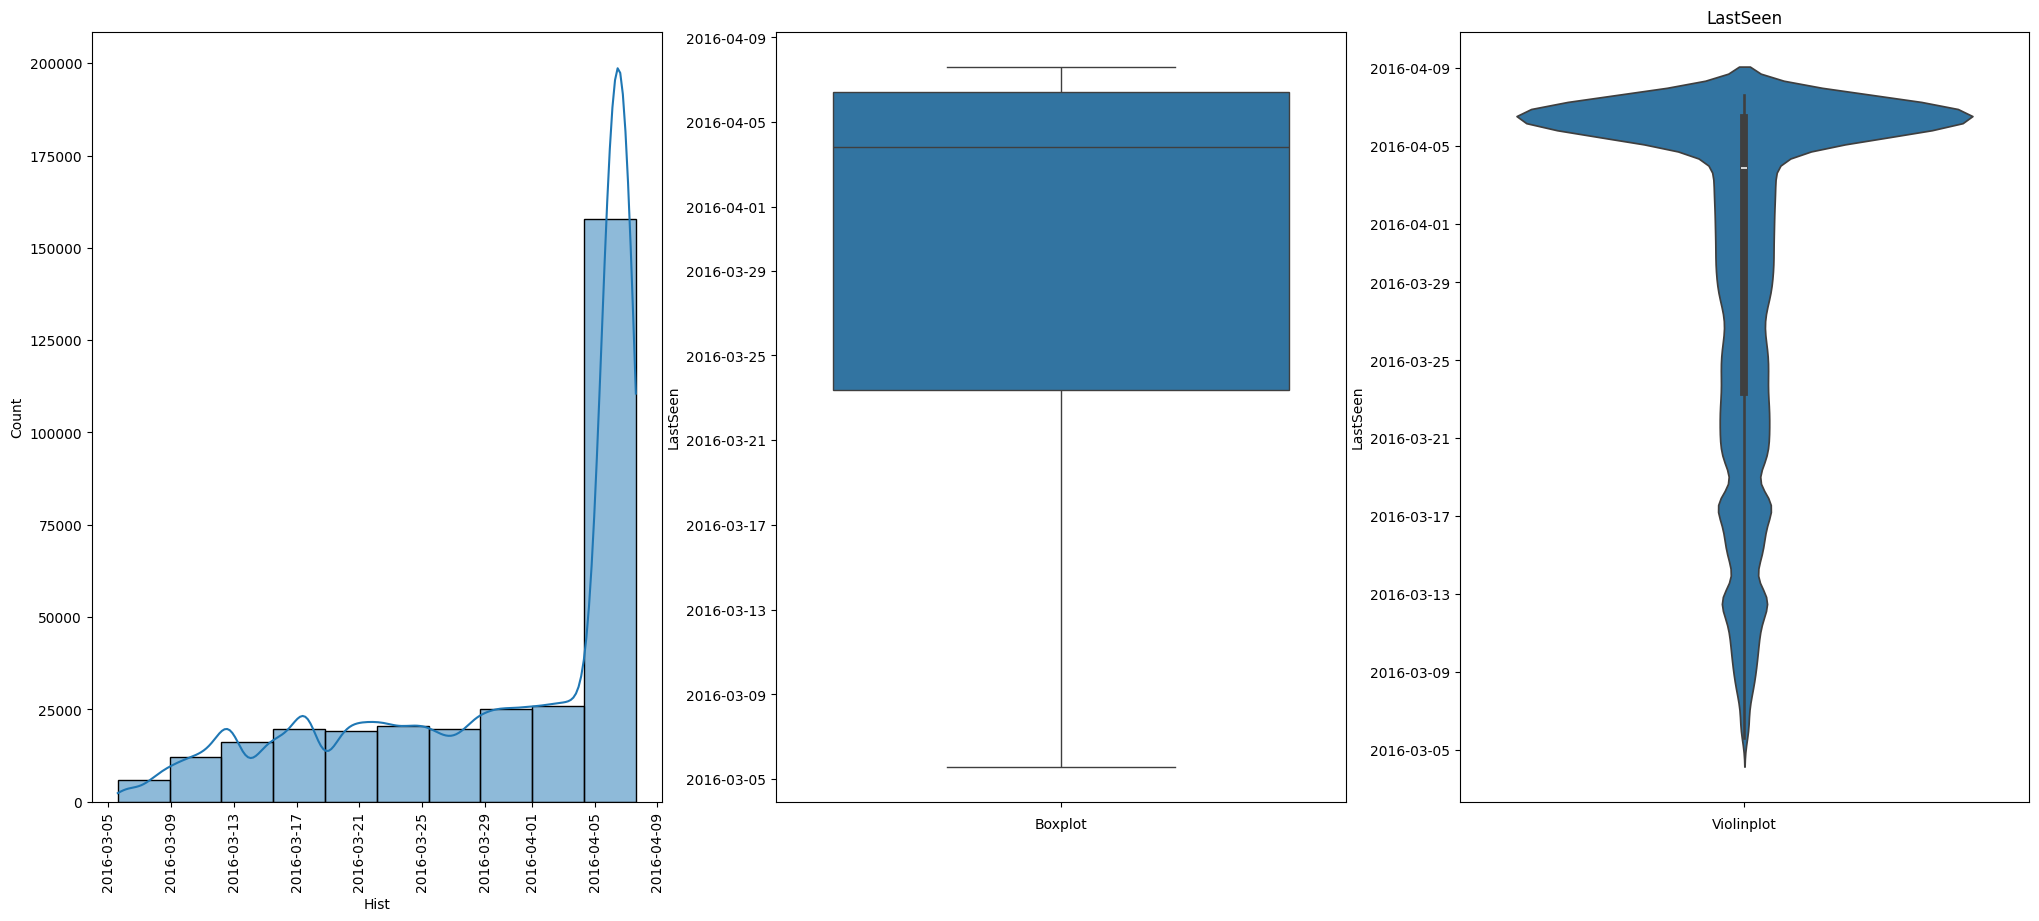

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

sns.histplot(data=df['LastSeen'], ax=axs[0], kde=True, bins=10)
axs[0].set_xlabel("Hist")
axs[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=df['LastSeen'], ax=axs[1])
axs[1].set_xlabel('Boxplot')

sns.violinplot(data=df['LastSeen'], ax=axs[2])
axs[2].set_xlabel('Violinplot')

plt.title('LastSeen')
plt.show()

Нет пользователей с слишком старой активонстью, никого удалять не придётся.

## Удаление признаков

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321912 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        321912 non-null  datetime64[ns]
 1   Price              321912 non-null  int64         
 2   VehicleType        321912 non-null  object        
 3   RegistrationYear   321912 non-null  int64         
 4   Gearbox            321912 non-null  object        
 5   Power              321912 non-null  float64       
 6   Model              321912 non-null  object        
 7   Great150           321912 non-null  bool          
 8   RegistrationMonth  321912 non-null  int64         
 9   FuelType           321912 non-null  object        
 10  Brand              321912 non-null  object        
 11  Repaired           321912 non-null  object        
 12  DateCreated        321912 non-null  datetime64[ns]
 13  PostalCode         321912 non-null  int64        

Удалим признаки DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen в силу их не информативности.

In [58]:
df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1, inplace=True) 

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321912 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             321912 non-null  int64  
 1   VehicleType       321912 non-null  object 
 2   RegistrationYear  321912 non-null  int64  
 3   Gearbox           321912 non-null  object 
 4   Power             321912 non-null  float64
 5   Model             321912 non-null  object 
 6   Great150          321912 non-null  bool   
 7   FuelType          321912 non-null  object 
 8   Brand             321912 non-null  object 
 9   Repaired          321912 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 24.9+ MB


## Корреляционный анализ

Посмотрим корреляционную матрицу

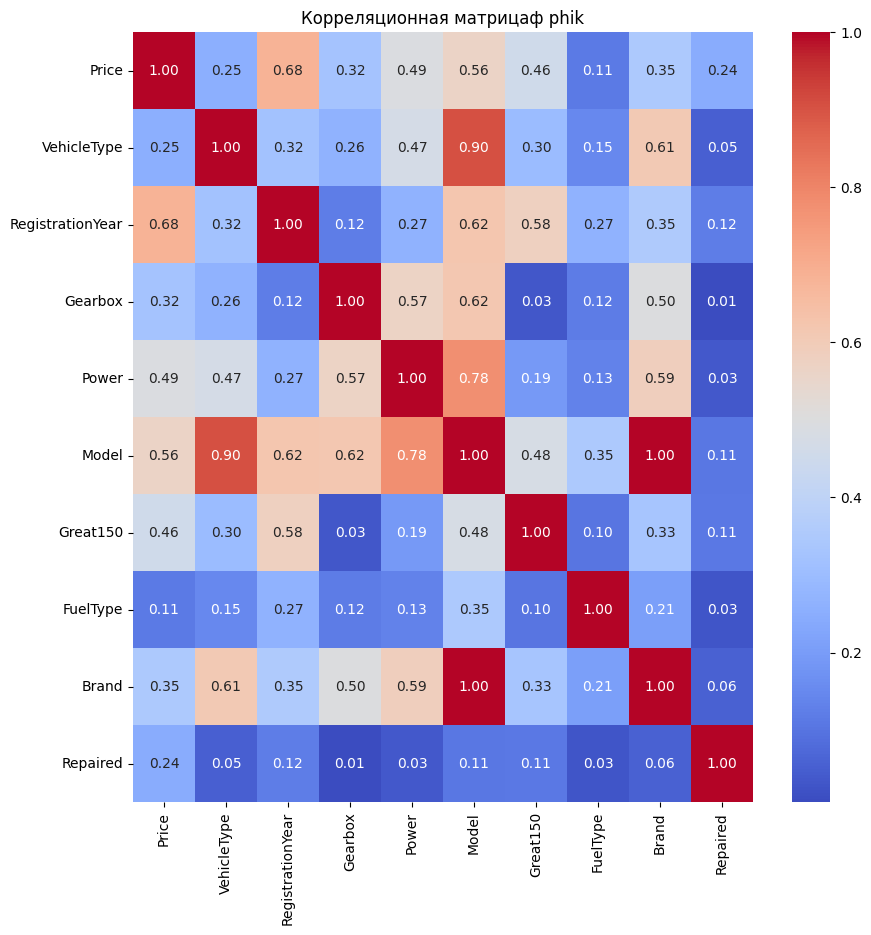

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(df.phik_matrix(interval_cols=df.select_dtypes(include=np.number)), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрицаф phik')
plt.show();

У Price со всеми признаками высокая корреляция. Между Model и Brand наблюдается мультиколлинеарность, поэтому лучше будет объединить колонки Brand и Model. Кроме того, она наблюдается между Model и VehicleType, если мы объединим с Brand, это станет получше.

In [61]:
df['Model'] = df['Brand'] + df['Model']
df.drop('Brand', axis=1, inplace=True)

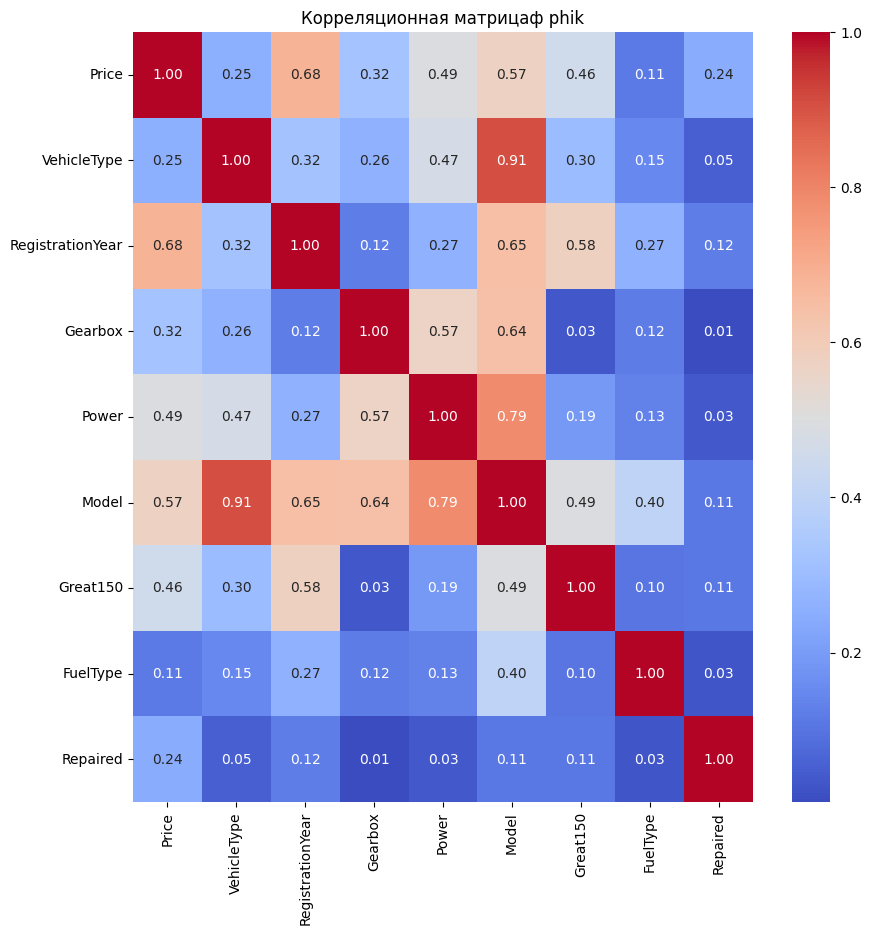

In [62]:
plt.figure(figsize=(10,10))
sns.heatmap(df.phik_matrix(interval_cols=df.select_dtypes(include=np.number)), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрицаф phik')
plt.show();

Коллинеарность Model и VehicleType побороть не получилось, поэтому оставим как есть.

# Разбиение данных

Разделим данные на тренировочную и тестовую выборки в соотношении 3:1.

In [63]:
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    random_state=RANDOM_STATE
)

Посмотрим корреляционные данные тренировочной и тестовой выборок, чтобы убедиться, что баланс данных не нарушен.

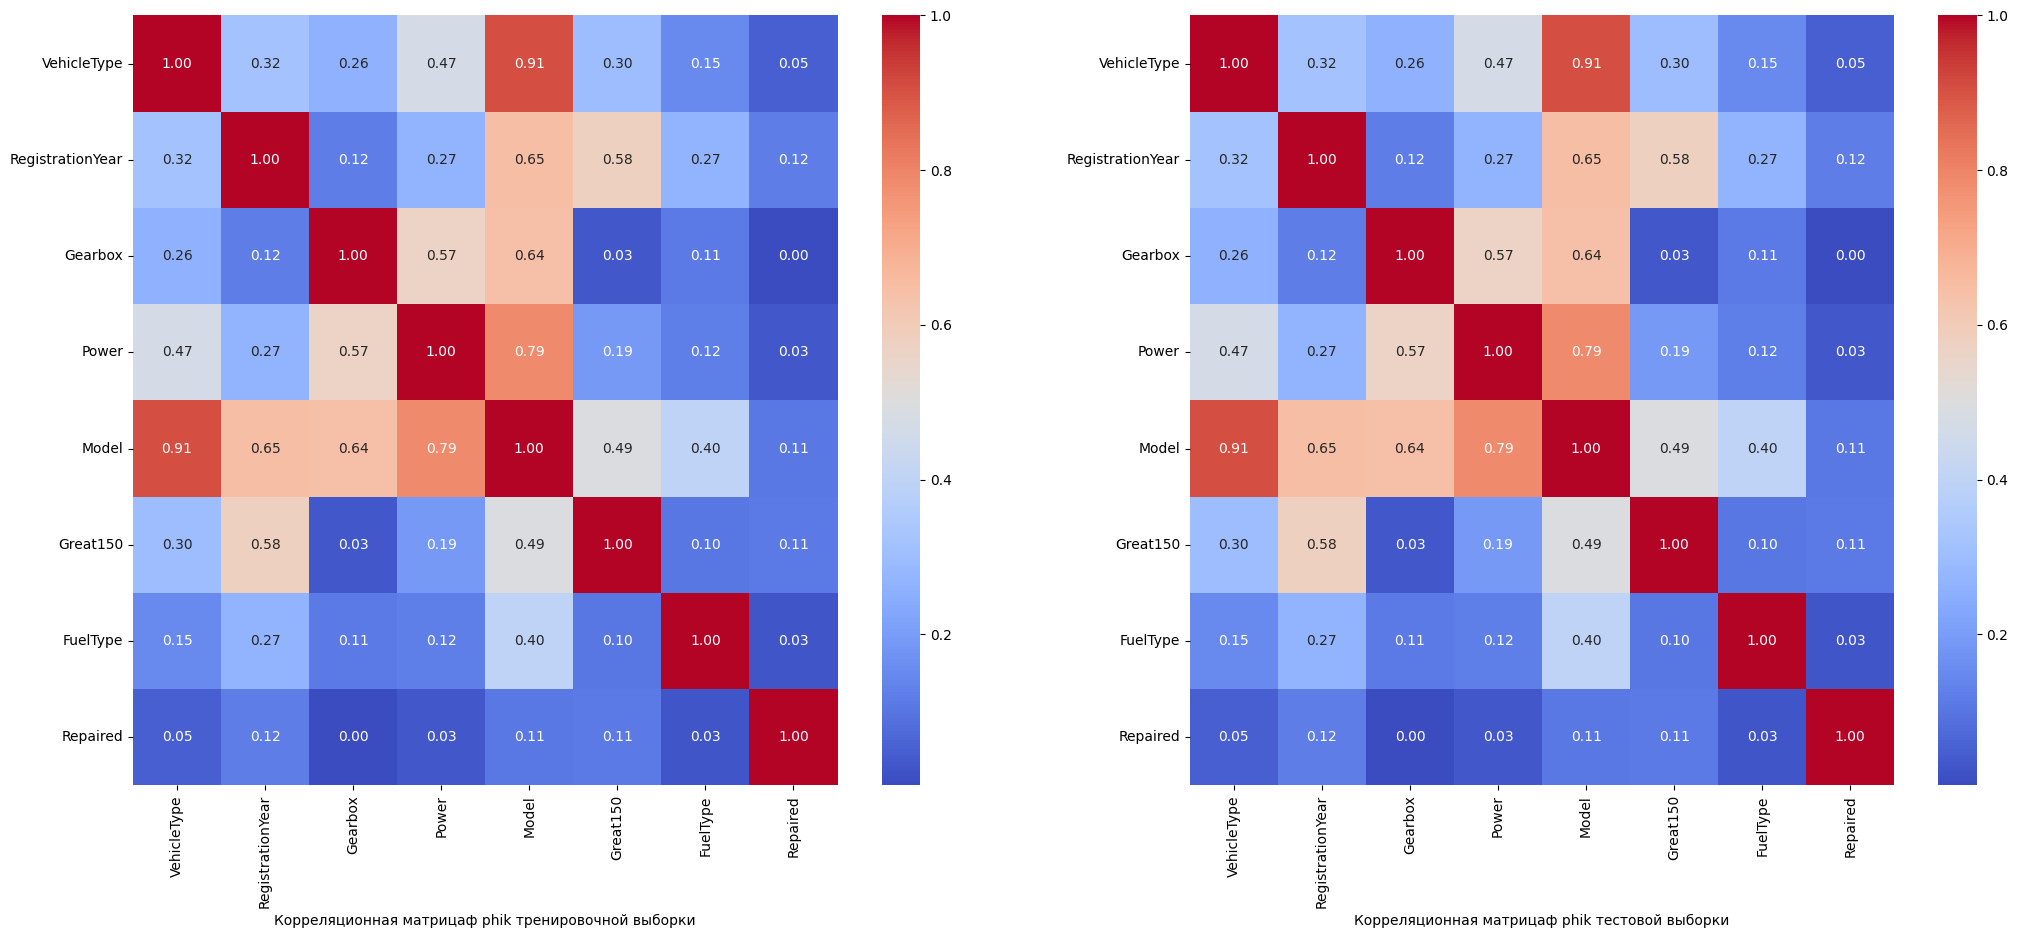

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,10))

plt.figure(figsize=(10,10))
sns.heatmap(X_train.phik_matrix(interval_cols=X_train.select_dtypes(include=np.number)), annot=True, cmap='coolwarm', fmt='.2f', ax=axs[0]);
axs[0].set_xlabel('Корреляционная матрицаф phik тренировочной выборки');

plt.figure(figsize=(10,10))
sns.heatmap(X_train.phik_matrix(interval_cols=X_train.select_dtypes(include=np.number)), annot=True, cmap='coolwarm', fmt='.2f', ax=axs[1]);
axs[1].set_xlabel('Корреляционная матрицаф phik тестовой выборки');

plt.show();

Заодно сразу создадим пайплайн для обучения моделей.

In [65]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'Great150', 'FuelType', 'Repaired']
num_columns = ['RegistrationYear', 'Power']

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('coder', 'passthrough', cat_columns),
        ('scaler', 'passthrough', num_columns)
    ], 
    remainder='passthrough'
)

pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('selector', SelectKBest()),
        ('model', None)
    ]
)

# Обучение моделей

Попробуем стандартные модели машинного обучения такие как kNN, DecisionTree и градиентные модели LightGBM, XGBoost, CatBoost. Каждую модель обучим с небольшим перебором, затем возьмём из них лучшую и обучим с долгим перебором, чтобы добиться максимальных параметров.

## XGBoost

XGBRegressor — это реализация алгоритма XGBoost для регрессии. Попробуем обучить её. Кроме того, замерим время подбора параметров и обучения.

In [66]:
%%time

param_grid_xgb = {
    'model': CategoricalDistribution([xgb.XGBRegressor(random_state=RANDOM_STATE)]),
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler()]),
    'preprocessor__coder': CategoricalDistribution(['passthrough', ohe_pipe]),
    'model__n_estimators': IntDistribution(1, 25),
    'model__min_tree_child_weight': IntDistribution(1, 5),
    'model__max_depth': IntDistribution(4, 8),
    'selector__k': IntDistribution(1, len(X_train.columns))
}

oscv_xgb = OptunaSearchCV(
    pipe, 
    param_grid_xgb, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_trials=35,
    random_state=RANDOM_STATE
)

oscv_xgb.fit(X_train, y_train)

[I 2024-07-12 01:54:57,353] A new study created in memory with name: no-name-2466fcc0-2805-4daf-84b4-d753b7f93a3f
[I 2024-07-12 01:55:17,607] Trial 0 finished with value: -3101.1258668293376 and parameters: {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, min_tree_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=13,
             n_jobs=None, num_parallel_tree=None, ...), 'preprocessor__scaler': StandardSc

CPU times: total: 5min 12s
Wall time: 3min 57s


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('coder',
                                                                           'passthrough',
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'Great150',
                                                                            'FuelType',
                                                                            'Repaired']),
                                                                          ('scaler',
                                                                           'passthrough',
                                                                           ['RegistrationYear',
                                                                            'Power'])])),
                                         ('selector', SelectKBest()),
                                         ('model', None)]),
               n_jobs=1, n_trials=35,
               param_distributions...
                                    'preprocessor__coder': CategoricalDistribution(choices=('passthrough', Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]))),
                                    'preprocessor__scaler': CategoricalDistribution(choices=('passthrough', StandardScaler())),
                                    'selector__k': IntDistribution(high=8, log=False, low=1, step=1)},
               random_state=42, scoring='neg_root_mean_squared_error')

In [67]:
oscv_xgb.best_score_ * -1

2120.5238691548593

In [68]:
oscv_xgb.best_params_

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, min_tree_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=23,
              n_jobs=None, num_parallel_tree=None, ...),
 'preprocessor__scaler': StandardScaler(),
 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                 ('ohe',
                  OneHotEncoder(drop='first', handle_unknow

Как видим, лучшая метрика - 2120 при параметрах n_estimators = 18, min_tree_child_weight = 2, max_depth = 7 и k = 8 (SelectorKBest). Из предобработчиков использовались StandardScaler и OneHotEncoder. Обучение модели и подбор параметров заняло 3 минуты 57 секунд. Посмотрим метрику на тестовой выборке и время предсказания.


In [69]:
%%time

print('RMSE на тестовой выборке:', root_mean_squared_error(oscv_xgb.predict(X_test), y_test) )
print('Время предсказания:')

RMSE на тестовой выборке: 2094.2972666192118
Время предсказания:
CPU times: total: 500 ms
Wall time: 420 ms


Модель получилась подходящей под условие, её можно использовать. Возможно, при более длительном подборе параметров получится результат лучше.

## CatBoost

CatBoost(Категориальный бустинг) — это высокопроизводительный фреймворк с открытым исходным кодом и градиентным бустингом, разработанный Яндексом. Попробуем регрессию.

In [70]:
%%time

pipe_boost = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('selector', SelectKBest()),
        ('model', cb.CatBoostRegressor(random_state=RANDOM_STATE))
    ]
)

param_grid_cb = {
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler()]),
    'preprocessor__coder': CategoricalDistribution(['passthrough', ohe_pipe]),
    'model__n_estimators': IntDistribution(1, 25),
    'model__depth': IntDistribution(4, 8),
    'selector__k': IntDistribution(1, len(X_train.columns))
}

oscv_cb = OptunaSearchCV(
    pipe_boost, 
    param_grid_cb, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_trials=35,
    random_state=RANDOM_STATE
)

oscv_cb.fit(X_train, y_train)

[I 2024-07-12 01:58:54,997] A new study created in memory with name: no-name-8d66daee-3709-41a8-a8d8-ca5f093d0780


Learning rate set to 0.5
0:	learn: 3258.9533891	total: 174ms	remaining: 2.08s
1:	learn: 2726.4025670	total: 189ms	remaining: 1.04s
2:	learn: 2536.0533383	total: 203ms	remaining: 678ms
3:	learn: 2458.5322104	total: 217ms	remaining: 488ms
4:	learn: 2399.3540809	total: 231ms	remaining: 369ms
5:	learn: 2377.6371313	total: 245ms	remaining: 286ms
6:	learn: 2361.9001935	total: 259ms	remaining: 222ms
7:	learn: 2352.2923826	total: 272ms	remaining: 170ms
8:	learn: 2341.4232611	total: 286ms	remaining: 127ms
9:	learn: 2334.5948073	total: 299ms	remaining: 89.8ms
10:	learn: 2328.0673554	total: 313ms	remaining: 56.9ms
11:	learn: 2322.9689809	total: 327ms	remaining: 27.3ms
12:	learn: 2319.1774860	total: 340ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 4020.6769700	total: 13ms	remaining: 156ms
1:	learn: 3868.9341563	total: 28.6ms	remaining: 158ms
2:	learn: 3808.1605173	total: 43.6ms	remaining: 145ms
3:	learn: 3772.6679500	total: 56.4ms	remaining: 127ms
4:	learn: 3750.0558577	total: 73.3ms	remain

[I 2024-07-12 01:59:14,550] Trial 0 finished with value: -3139.053969946909 and parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 13, 'model__depth': 5, 'selector__k': 2}. Best is trial 0 with value: -3139.053969946909.


Learning rate set to 0.5
0:	learn: 3203.4920013	total: 17.6ms	remaining: 423ms
1:	learn: 2675.9854225	total: 37.1ms	remaining: 427ms
2:	learn: 2471.5722345	total: 53.7ms	remaining: 394ms
3:	learn: 2392.5271231	total: 69.9ms	remaining: 367ms
4:	learn: 2358.7807307	total: 90.5ms	remaining: 362ms
5:	learn: 2343.9590751	total: 105ms	remaining: 334ms
6:	learn: 2331.7268724	total: 123ms	remaining: 315ms
7:	learn: 2324.0702190	total: 138ms	remaining: 294ms
8:	learn: 2317.6314186	total: 154ms	remaining: 274ms
9:	learn: 2314.2093641	total: 172ms	remaining: 258ms
10:	learn: 2308.0793451	total: 190ms	remaining: 242ms
11:	learn: 2302.4543167	total: 211ms	remaining: 228ms
12:	learn: 2298.5802975	total: 227ms	remaining: 209ms
13:	learn: 2296.7599459	total: 247ms	remaining: 194ms
14:	learn: 2294.1838577	total: 263ms	remaining: 175ms
15:	learn: 2288.6583352	total: 279ms	remaining: 157ms
16:	learn: 2286.1118511	total: 295ms	remaining: 139ms
17:	learn: 2285.1035220	total: 312ms	remaining: 121ms
18:	lear

[I 2024-07-12 01:59:37,454] Trial 1 finished with value: -3092.254355410206 and parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 25, 'model__depth': 6, 'selector__k': 2}. Best is trial 1 with value: -3092.254355410206.


Learning rate set to 0.5
0:	learn: 3115.0890172	total: 24.7ms	remaining: 271ms
1:	learn: 2564.6614189	total: 45.4ms	remaining: 227ms
2:	learn: 2357.7272804	total: 65ms	remaining: 195ms
3:	learn: 2282.4000731	total: 87.6ms	remaining: 175ms
4:	learn: 2255.5001176	total: 107ms	remaining: 150ms
5:	learn: 2233.8687792	total: 133ms	remaining: 133ms
6:	learn: 2226.0035882	total: 151ms	remaining: 108ms
7:	learn: 2220.4535846	total: 174ms	remaining: 86.8ms
8:	learn: 2213.3922219	total: 198ms	remaining: 66ms
9:	learn: 2207.9302700	total: 218ms	remaining: 43.6ms
10:	learn: 2204.5827673	total: 238ms	remaining: 21.7ms
11:	learn: 2197.6807967	total: 259ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3114.4204932	total: 23.6ms	remaining: 259ms
1:	learn: 2565.3713337	total: 46.3ms	remaining: 231ms
2:	learn: 2357.3560965	total: 68.6ms	remaining: 206ms
3:	learn: 2282.1116207	total: 93.1ms	remaining: 186ms
4:	learn: 2254.0683334	total: 113ms	remaining: 158ms
5:	learn: 2237.1712841	total: 132ms	remai

[I 2024-07-12 01:59:57,109] Trial 2 finished with value: -2198.4416686864993 and parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 12, 'model__depth': 8, 'selector__k': 4}. Best is trial 2 with value: -2198.4416686864993.


Learning rate set to 0.5
0:	learn: 3116.8866939	total: 22.1ms	remaining: 441ms
1:	learn: 2552.7789663	total: 42.8ms	remaining: 406ms
2:	learn: 2351.7801722	total: 63.2ms	remaining: 379ms
3:	learn: 2281.0878305	total: 83.9ms	remaining: 357ms
4:	learn: 2256.7084714	total: 107ms	remaining: 342ms
5:	learn: 2235.2792689	total: 127ms	remaining: 318ms
6:	learn: 2225.1303491	total: 149ms	remaining: 298ms
7:	learn: 2218.0099614	total: 171ms	remaining: 278ms
8:	learn: 2214.4363969	total: 191ms	remaining: 254ms
9:	learn: 2206.8960679	total: 216ms	remaining: 237ms
10:	learn: 2200.6096626	total: 237ms	remaining: 215ms
11:	learn: 2194.0522758	total: 257ms	remaining: 193ms
12:	learn: 2190.5067720	total: 278ms	remaining: 171ms
13:	learn: 2186.8719840	total: 304ms	remaining: 152ms
14:	learn: 2184.9130071	total: 323ms	remaining: 129ms
15:	learn: 2183.2181286	total: 343ms	remaining: 107ms
16:	learn: 2181.5979153	total: 361ms	remaining: 84.9ms
17:	learn: 2177.1174752	total: 385ms	remaining: 64.2ms
18:	lea

[I 2024-07-12 02:00:17,701] Trial 3 finished with value: -2177.1207802969825 and parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 21, 'model__depth': 8, 'selector__k': 5}. Best is trial 3 with value: -2177.1207802969825.


Learning rate set to 0.5
0:	learn: 3319.1616528	total: 16.5ms	remaining: 82.3ms
1:	learn: 2708.3243414	total: 34.5ms	remaining: 69ms
2:	learn: 2487.6172323	total: 49.8ms	remaining: 49.8ms
3:	learn: 2380.7721439	total: 65.2ms	remaining: 32.6ms
4:	learn: 2330.2440315	total: 81.2ms	remaining: 16.2ms
5:	learn: 2300.6579153	total: 96.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3298.3198044	total: 14.2ms	remaining: 71ms
1:	learn: 2719.2653488	total: 30.4ms	remaining: 60.8ms
2:	learn: 2476.7545930	total: 43ms	remaining: 43ms
3:	learn: 2375.0449226	total: 57.5ms	remaining: 28.8ms
4:	learn: 2330.5125986	total: 73.7ms	remaining: 14.7ms
5:	learn: 2305.8793321	total: 87.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3291.1057883	total: 13.3ms	remaining: 66.7ms
1:	learn: 2746.4883024	total: 27.2ms	remaining: 54.5ms
2:	learn: 2494.6389041	total: 42.9ms	remaining: 42.9ms
3:	learn: 2381.2039334	total: 59.3ms	remaining: 29.6ms
4:	learn: 2338.2937033	total: 74.3ms	remaining: 14.9ms
5:	l

[I 2024-07-12 02:00:37,392] Trial 4 finished with value: -2307.532594046847 and parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 6, 'model__depth': 5, 'selector__k': 7}. Best is trial 3 with value: -2177.1207802969825.
[W 2024-07-12 02:00:38,171] Trial 5 failed with parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': 'passthrough', 'model__n_estimators': 7, 'model__depth': 5, 'selector__k': 6} because of the following error: The value nan is not acceptable.
[W 2024-07-12 02:00:38,172] Trial 5 failed with value nan.


Learning rate set to 0.5
0:	learn: 3201.8402727	total: 20.8ms	remaining: 249ms
1:	learn: 2609.6164989	total: 41.7ms	remaining: 229ms
2:	learn: 2398.5527976	total: 57ms	remaining: 190ms
3:	learn: 2319.2476427	total: 72.3ms	remaining: 163ms
4:	learn: 2271.7914577	total: 87ms	remaining: 139ms
5:	learn: 2252.2581953	total: 104ms	remaining: 122ms
6:	learn: 2240.8628783	total: 118ms	remaining: 101ms
7:	learn: 2231.9176454	total: 135ms	remaining: 84.3ms
8:	learn: 2221.4520937	total: 150ms	remaining: 66.5ms
9:	learn: 2218.1119382	total: 164ms	remaining: 49.3ms
10:	learn: 2212.5893484	total: 182ms	remaining: 33ms
11:	learn: 2208.6400715	total: 200ms	remaining: 16.7ms
12:	learn: 2200.9217210	total: 216ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3219.1489320	total: 15.6ms	remaining: 187ms
1:	learn: 2644.9096526	total: 31ms	remaining: 171ms
2:	learn: 2422.0549747	total: 65.7ms	remaining: 219ms
3:	learn: 2334.9424096	total: 97.4ms	remaining: 219ms
4:	learn: 2297.1333960	total: 145ms	remain

[I 2024-07-12 02:00:58,544] Trial 6 finished with value: -2220.404330101171 and parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 13, 'model__depth': 6, 'selector__k': 7}. Best is trial 3 with value: -2177.1207802969825.


Learning rate set to 0.5
0:	learn: 4009.0419032	total: 14.7ms	remaining: 118ms
1:	learn: 3864.4848565	total: 32ms	remaining: 112ms
2:	learn: 3808.7070871	total: 48ms	remaining: 96.1ms
3:	learn: 3755.7970179	total: 65.2ms	remaining: 81.5ms
4:	learn: 3731.2688947	total: 80.6ms	remaining: 64.4ms
5:	learn: 3716.9641479	total: 95ms	remaining: 47.5ms
6:	learn: 3707.6190667	total: 110ms	remaining: 31.4ms
7:	learn: 3693.3168454	total: 123ms	remaining: 15.4ms
8:	learn: 3686.8352605	total: 138ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 4492.3474968	total: 7.43ms	remaining: 59.5ms
1:	learn: 4492.2927241	total: 14.7ms	remaining: 51.4ms
2:	learn: 4492.2683806	total: 21.5ms	remaining: 43.1ms
3:	learn: 4492.2575614	total: 28.9ms	remaining: 36.1ms
4:	learn: 4492.2527528	total: 35.9ms	remaining: 28.7ms
5:	learn: 4492.2506157	total: 42.6ms	remaining: 21.3ms
6:	learn: 4492.2496658	total: 49.4ms	remaining: 14.1ms
7:	learn: 4492.2492437	total: 56.5ms	remaining: 7.07ms
8:	learn: 4492.2490561	total:

[I 2024-07-12 02:01:21,941] Trial 7 finished with value: -4018.287957542242 and parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 9, 'model__depth': 6, 'selector__k': 1}. Best is trial 3 with value: -2177.1207802969825.


Learning rate set to 0.5
0:	learn: 3307.9583078	total: 28.6ms	remaining: 486ms
1:	learn: 2691.9650929	total: 49.7ms	remaining: 397ms
2:	learn: 2461.6072826	total: 64.7ms	remaining: 324ms
3:	learn: 2373.5429326	total: 82.9ms	remaining: 290ms
4:	learn: 2317.0296397	total: 97.7ms	remaining: 254ms
5:	learn: 2286.4330953	total: 115ms	remaining: 230ms
6:	learn: 2272.5593646	total: 130ms	remaining: 204ms
7:	learn: 2263.2023196	total: 147ms	remaining: 183ms
8:	learn: 2252.5122560	total: 164ms	remaining: 164ms
9:	learn: 2247.8535585	total: 179ms	remaining: 144ms
10:	learn: 2242.8846307	total: 197ms	remaining: 125ms
11:	learn: 2239.5040278	total: 223ms	remaining: 112ms
12:	learn: 2234.3858285	total: 238ms	remaining: 91.5ms
13:	learn: 2228.1315779	total: 260ms	remaining: 74.2ms
14:	learn: 2218.5215724	total: 278ms	remaining: 55.7ms
15:	learn: 2212.0514927	total: 295ms	remaining: 36.8ms
16:	learn: 2210.2922793	total: 314ms	remaining: 18.4ms
17:	learn: 2206.7215205	total: 337ms	remaining: 0us
Learn

[I 2024-07-12 02:01:48,389] Trial 8 finished with value: -2215.308046947045 and parameters: {'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 18, 'model__depth': 5, 'selector__k': 6}. Best is trial 3 with value: -2177.1207802969825.


Learning rate set to 0.5
0:	learn: 3391.7453498	total: 16.4ms	remaining: 360ms
1:	learn: 2802.1581940	total: 33ms	remaining: 347ms
2:	learn: 2545.8874738	total: 49.5ms	remaining: 330ms
3:	learn: 2448.4443659	total: 63.1ms	remaining: 300ms
4:	learn: 2382.8579247	total: 74.6ms	remaining: 269ms
5:	learn: 2348.9686179	total: 87.5ms	remaining: 248ms
6:	learn: 2321.3552940	total: 105ms	remaining: 240ms
7:	learn: 2307.4482315	total: 115ms	remaining: 216ms
8:	learn: 2300.3057552	total: 129ms	remaining: 200ms
9:	learn: 2284.4959734	total: 147ms	remaining: 191ms
10:	learn: 2275.7559684	total: 166ms	remaining: 181ms
11:	learn: 2267.0673471	total: 181ms	remaining: 166ms
12:	learn: 2261.8544221	total: 195ms	remaining: 150ms
13:	learn: 2255.3015953	total: 211ms	remaining: 135ms
14:	learn: 2251.2283469	total: 227ms	remaining: 121ms
15:	learn: 2244.5937900	total: 246ms	remaining: 107ms
16:	learn: 2241.3834009	total: 260ms	remaining: 91.6ms
17:	learn: 2239.8432056	total: 278ms	remaining: 77.4ms
18:	lea

[I 2024-07-12 02:02:11,499] Trial 9 finished with value: -2227.641674457354 and parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 23, 'model__depth': 4, 'selector__k': 4}. Best is trial 3 with value: -2177.1207802969825.
[W 2024-07-12 02:02:12,298] Trial 10 failed with parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': 'passthrough', 'model__n_estimators': 9, 'model__depth': 5, 'selector__k': 6} because of the following error: The value nan is not acceptable.
[W 2024-07-12 02:02:12,299] Trial 10 failed with value nan.


Learning rate set to 0.5
0:	learn: 3377.7826892	total: 17.5ms	remaining: 192ms
1:	learn: 2787.1119797	total: 34.1ms	remaining: 171ms
2:	learn: 2523.7934398	total: 50.1ms	remaining: 150ms
3:	learn: 2424.8137972	total: 65.8ms	remaining: 132ms
4:	learn: 2354.2093148	total: 80.5ms	remaining: 113ms
5:	learn: 2327.6102965	total: 98.9ms	remaining: 98.9ms
6:	learn: 2302.9546386	total: 118ms	remaining: 84.6ms
7:	learn: 2295.4990240	total: 135ms	remaining: 67.5ms
8:	learn: 2284.3712051	total: 151ms	remaining: 50.4ms
9:	learn: 2271.7156738	total: 173ms	remaining: 34.5ms
10:	learn: 2266.2801099	total: 189ms	remaining: 17.1ms
11:	learn: 2263.6310330	total: 205ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3377.1204375	total: 21.3ms	remaining: 234ms
1:	learn: 2797.2325434	total: 36.8ms	remaining: 184ms
2:	learn: 2570.7901638	total: 57.3ms	remaining: 172ms
3:	learn: 2437.8747397	total: 72.1ms	remaining: 144ms
4:	learn: 2376.0818895	total: 94.7ms	remaining: 133ms
5:	learn: 2336.7197624	total: 11

[I 2024-07-12 02:02:34,247] Trial 11 finished with value: -2265.6833360532883 and parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 12, 'model__depth': 4, 'selector__k': 6}. Best is trial 3 with value: -2177.1207802969825.
[W 2024-07-12 02:02:35,119] Trial 12 failed with parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': 'passthrough', 'model__n_estimators': 20, 'model__depth': 8, 'selector__k': 8} because of the following error: The value nan is not acceptable.
[W 2024-07-12 02:02:35,119] Trial 12 failed with value nan.
[W 2024-07-12 02:02:35,915] Trial 13 failed with parameters: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': 'passthrough', 'model__n_estimators': 1, 'model

Learning rate set to 0.5
0:	learn: 3130.0844647	total: 41.3ms	remaining: 826ms
1:	learn: 2569.5442388	total: 75.4ms	remaining: 717ms
2:	learn: 2365.8841124	total: 108ms	remaining: 649ms
3:	learn: 2285.4654174	total: 147ms	remaining: 623ms
4:	learn: 2252.0127876	total: 208ms	remaining: 666ms
5:	learn: 2233.8499975	total: 241ms	remaining: 602ms
6:	learn: 2222.9537860	total: 264ms	remaining: 528ms
7:	learn: 2214.5478896	total: 289ms	remaining: 470ms
8:	learn: 2209.9819481	total: 308ms	remaining: 411ms
9:	learn: 2205.9020523	total: 328ms	remaining: 361ms
10:	learn: 2201.2915883	total: 349ms	remaining: 317ms
11:	learn: 2197.4626362	total: 366ms	remaining: 275ms
12:	learn: 2189.6305769	total: 387ms	remaining: 238ms
13:	learn: 2186.1664707	total: 406ms	remaining: 203ms
14:	learn: 2182.7867697	total: 469ms	remaining: 187ms
15:	learn: 2180.9251546	total: 514ms	remaining: 161ms
16:	learn: 2177.9253709	total: 558ms	remaining: 131ms
17:	learn: 2173.6263466	total: 599ms	remaining: 99.8ms
18:	learn:

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('coder',
                                                                           'passthrough',
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'Great150',
                                                                            'FuelType',
                                                                            'Repaired']),
                                                                          ('scaler',
                                                                           'passthrough',
                                                                           ['RegistrationYear',
                                                                            'Power'])])),
                                         ('selector', SelectKBest()),
                                         ('model',
                                          <catboost.core.CatBoostRegressor object at 0x000002...
                                    'preprocessor__coder': CategoricalDistribution(choices=('passthrough', Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]))),
                                    'preprocessor__scaler': CategoricalDistribution(choices=('passthrough', StandardScaler())),
                                    'selector__k': IntDistribution(high=8, log=False, low=1, step=1)},
               random_state=42, scoring='neg_root_mean_squared_error')

Как видим, время поиска заняло 4 минуты 4 секунды, посмотрим лучшую модель.

In [71]:
print('Лучший результат:', oscv_cb.best_score_ * -1)

Лучший результат: 2177.1207802969825


In [72]:
print('Лучшая модель:', oscv_cb.best_params_)

Лучшая модель: {'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 21, 'model__depth': 8, 'selector__k': 5}


Параметры для лучшей модели - это n_estimators=21, model_depth=8, k=5. Из предобработчиков использовался только OneHotEncoder.

In [73]:
%%time

print('RMSE на тестовой выборке:', root_mean_squared_error(oscv_cb.predict(X_test), y_test))
print('Время предсказания:')

RMSE на тестовой выборке: 2156.017360199266
Время предсказания:
CPU times: total: 469 ms
Wall time: 471 ms


Эта модель вышла хуже предыдущей, но тоже подходящей под условие.

## LightGBM

LightGBM (Light Gradient Boosting Machine) - это библиотека для градиентного бустинга, разработанная компанией Microsoft. Попробуем регрессию LightGBM.

In [74]:
%%time

param_grid_lgb = {
    'model': CategoricalDistribution([lgb.LGBMRegressor(random_state=RANDOM_STATE)]),
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler()]),
    'preprocessor__coder': CategoricalDistribution(['passthrough', ohe_pipe]),
    'model__n_estimators': IntDistribution(1, 25),
    'model__max_depth': IntDistribution(4, 8),
    'model__num_leaves': IntDistribution(2, 20),
    'selector__k': IntDistribution(1, len(X_train.columns))
}

oscv_lgb = OptunaSearchCV(
    pipe, 
    param_grid_lgb, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_trials=35,
    random_state=RANDOM_STATE
)

oscv_lgb.fit(X_train, y_train)

[I 2024-07-12 02:02:59,981] A new study created in memory with name: no-name-d89a5f3c-26aa-4ce5-949f-641dbc0e30bb


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 2
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 1
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

[I 2024-07-12 02:03:24,036] Trial 0 finished with value: -3424.6847142228244 and parameters: {'model': LGBMRegressor(max_depth=5, n_estimators=13, num_leaves=6, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 13, 'model__max_depth': 5, 'model__num_leaves': 6, 'selector__k': 2}. Best is trial 0 with value: -3424.6847142228244.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 3
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 3
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2024-07-12 02:03:45,475] Trial 1 finished with value: -2651.8107964736387 and parameters: {'model': LGBMRegressor(max_depth=5, n_estimators=13, num_leaves=9, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 13, 'model__max_depth': 5, 'model__num_leaves': 9, 'selector__k': 4}. Best is trial 1 with value: -2651.8107964736387.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 1
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 0
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

[I 2024-07-12 02:04:06,971] Trial 2 finished with value: -4050.1236979708146 and parameters: {'model': LGBMRegressor(max_depth=8, n_estimators=12, num_leaves=18, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 12, 'model__max_depth': 8, 'model__num_leaves': 18, 'selector__k': 1}. Best is trial 1 with value: -2651.8107964736387.
[W 2024-07-12 02:04:08,053] Trial 3 failed with parameters: {'model': LGBMRegressor(max_depth=7, n_estimators=3, num_leaves=11, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': 'passthrough', 'model__n_estimators': 3, 'model__max_depth': 7, 'model__num_leaves': 11, 'selector__k': 5} because of the following error: The value nan is not acceptable.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 3
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 3
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2024-07-12 02:04:30,206] Trial 5 finished with value: -3568.0475897880483 and parameters: {'model': LGBMRegressor(max_depth=6, n_estimators=4, num_leaves=11, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 4, 'model__max_depth': 6, 'model__num_leaves': 11, 'selector__k': 4}. Best is trial 1 with value: -2651.8107964736387.
[W 2024-07-12 02:04:31,096] Trial 6 failed with parameters: {'model': LGBMRegressor(max_depth=5, n_estimators=17, num_leaves=10, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': 'passthrough', 'model__n_estimators': 17, 'model__max_depth': 5, 'model__num_leaves': 10, 'selector__k': 1} because of the following error: The value nan is not acceptable.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 7
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 7
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2024-07-12 02:04:52,600] Trial 7 finished with value: -2374.462348821644 and parameters: {'model': LGBMRegressor(max_depth=5, n_estimators=18, num_leaves=15, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 18, 'model__max_depth': 5, 'model__num_leaves': 15, 'selector__k': 8}. Best is trial 7 with value: -2374.462348821644.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 1
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 0
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

[I 2024-07-12 02:05:14,663] Trial 8 finished with value: -4420.956786873977 and parameters: {'model': LGBMRegressor(max_depth=6, n_estimators=1, num_leaves=11, random_state=42), 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 1, 'model__max_depth': 6, 'model__num_leaves': 11, 'selector__k': 1}. Best is trial 7 with value: -2374.462348821644.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 2
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 2
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2024-07-12 02:05:41,388] Trial 9 finished with value: -2548.292774221753 and parameters: {'model': LGBMRegressor(max_depth=6, n_estimators=18, num_leaves=7, random_state=42), 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 18, 'model__max_depth': 6, 'model__num_leaves': 7, 'selector__k': 3}. Best is trial 7 with value: -2374.462348821644.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 2
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 1
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2024-07-12 02:06:01,624] Trial 10 finished with value: -3242.552735853244 and parameters: {'model': LGBMRegressor(max_depth=7, n_estimators=14, num_leaves=19, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 14, 'model__max_depth': 7, 'model__num_leaves': 19, 'selector__k': 2}. Best is trial 7 with value: -2374.462348821644.
[W 2024-07-12 02:06:02,360] Trial 11 failed with parameters: {'model': LGBMRegressor(max_depth=7, n_estimators=10, num_leaves=19, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': 'passthrough', 'model__n_estimators': 10, 'model__max_depth': 7, 'model__num_leaves': 19, 'selector__k': 8} because of the following error: The value nan is not acceptabl

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 6
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 6
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2024-07-12 02:06:23,013] Trial 13 finished with value: -3338.3065088381895 and parameters: {'model': LGBMRegressor(max_depth=6, n_estimators=5, num_leaves=17, random_state=42), 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 5, 'model__max_depth': 6, 'model__num_leaves': 17, 'selector__k': 7}. Best is trial 7 with value: -2374.462348821644.
[W 2024-07-12 02:06:23,627] Trial 14 failed with parameters: {'model': LGBMRegressor(max_depth=7, n_estimators=11, num_leaves=10, random_state=42), 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': 'passthrough', 'model__n_estimators': 11, 'model__max_depth': 7, 'model__num_leaves': 10, 'selector__k': 1} because of the following error: The value nan is not acceptable.
[W 2

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 7
[LightGBM] [Info] Start training from score 4767.883591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 193147, number of used features: 7
[LightGBM] [Info] Start training from score 4766.667041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2024-07-12 02:06:40,212] Trial 15 finished with value: -3914.5338827460873 and parameters: {'model': LGBMRegressor(max_depth=7, n_estimators=6, num_leaves=2, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 6, 'model__max_depth': 7, 'model__num_leaves': 2, 'selector__k': 8}. Best is trial 7 with value: -2374.462348821644.
[W 2024-07-12 02:06:40,798] Trial 16 failed with parameters: {'model': LGBMRegressor(max_depth=4, n_estimators=25, num_leaves=15, random_state=42), 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': 'passthrough', 'model__n_estimators': 25, 'model__max_depth': 4, 'model__num_leaves': 15, 'selector__k': 6} because of the following error: The value nan is not acceptable.
[W 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 241434, number of used features: 7
[LightGBM] [Info] Start training from score 4770.697441
CPU times: total: 4min 32s
Wall time: 3min 55s


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('coder',
                                                                           'passthrough',
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'Great150',
                                                                            'FuelType',
                                                                            'Repaired']),
                                                                          ('scaler',
                                                                           'passthrough',
                                                                           ['RegistrationYear',
                                                                            'Power'])])),
                                         ('selector', SelectKBest()),
                                         ('model', None)]),
               n_jobs=1, n_trials=35,
               param_distributions...
                                    'preprocessor__coder': CategoricalDistribution(choices=('passthrough', Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]))),
                                    'preprocessor__scaler': CategoricalDistribution(choices=('passthrough', StandardScaler())),
                                    'selector__k': IntDistribution(high=8, log=False, low=1, step=1)},
               random_state=42, scoring='neg_root_mean_squared_error')

Обучение заняло 4 минуты 32 секунды, посмотрим результаты.

In [75]:
print('Лучший результат:', oscv_lgb.best_score_ * -1)

Лучший результат: 2374.462348821644


In [76]:
print('Лучшая модель:', oscv_lgb.best_params_)

Лучшая модель: {'model': LGBMRegressor(max_depth=4, n_estimators=23, num_leaves=15, random_state=42), 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__n_estimators': 18, 'model__max_depth': 5, 'model__num_leaves': 15, 'selector__k': 8}


In [77]:
%%time

print('RMSE на тестовой выборке:', root_mean_squared_error(oscv_lgb.predict(X_test), y_test))
print('Время предсказания:')

RMSE на тестовой выборке: 2348.510623286623
Время предсказания:
CPU times: total: 469 ms
Wall time: 427 ms


Эта модель вышла худшей из всех градиентных моделей, но под требования заказчика она всё ещё подходит. Параметры этой модели n_estimators = 23, max_depth = 4, num_leaves = 15, k = 8, из предобработчиков используем OneHotEncoder, StandardScaler.

## kNN

Посмотрим модели классического машинного обучения.

In [78]:
%%time

param_grid_knn = {
    'model': CategoricalDistribution([KNeighborsRegressor()]),
    'model__n_neighbors': IntDistribution(2, 15),
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler()]),
    'preprocessor__coder': CategoricalDistribution(['passthrough', ohe_pipe]),
    'model__metric': CategoricalDistribution(['euclidean', 'minkowski']),
    'model__weights': CategoricalDistribution(['uniform', 'distance']),
    'selector__k': IntDistribution(1, len(X.columns))
}

oscv_knn = OptunaSearchCV(
    pipe, 
    param_grid_knn, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    n_trials=35, 
    refit='recall'
)
oscv_knn.fit(X_train, y_train) 

[I 2024-07-12 02:06:56,007] A new study created in memory with name: no-name-04593cb1-5f22-4d82-be30-d23c2240afe8
[I 2024-07-12 02:07:24,045] Trial 0 finished with value: -2175.8418350920592 and parameters: {'model': KNeighborsRegressor(n_neighbors=11), 'model__n_neighbors': 11, 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__metric': 'minkowski', 'model__weights': 'uniform', 'selector__k': 4}. Best is trial 0 with value: -2175.8418350920592.
[I 2024-07-12 02:07:49,802] Trial 1 finished with value: -2375.154527819672 and parameters: {'model': KNeighborsRegressor(metric='euclidean', n_neighbors=3, weights='distance'), 'model__n_neighbors': 3, 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_o

CPU times: total: 7min 26s
Wall time: 7min 34s


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('coder',
                                                                           'passthrough',
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'Great150',
                                                                            'FuelType',
                                                                            'Repaired']),
                                                                          ('scaler',
                                                                           'passthrough',
                                                                           ['RegistrationYear',
                                                                            'Power'])])),
                                         ('selector', SelectKBest()),
                                         ('model', None)]),
               n_jobs=1, n_trials=35,
               param_distributions...
                                    'preprocessor__coder': CategoricalDistribution(choices=('passthrough', Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]))),
                                    'preprocessor__scaler': CategoricalDistribution(choices=('passthrough', StandardScaler())),
                                    'selector__k': IntDistribution(high=8, log=False, low=1, step=1)},
               refit='recall', scoring='neg_root_mean_squared_error')

In [79]:
print('Лучший результат:', oscv_knn.best_score_ * -1)

Лучший результат: 2164.0514590377


In [80]:
print('Лучшая модель:', oscv_knn.best_params_)

Лучшая модель: {'model': KNeighborsRegressor(n_neighbors=15), 'model__n_neighbors': 9, 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'model__metric': 'minkowski', 'model__weights': 'uniform', 'selector__k': 8}


In [81]:
%%time

print('RMSE на тестовой выборке:', root_mean_squared_error(oscv_knn.predict(X_test), y_test))
print('Время предсказания:')

RMSE на тестовой выборке: 2135.9473618700117
Время предсказания:
CPU times: total: 6.41 s
Wall time: 6.53 s


Эта модель вышла лучше, чем 2 из 3 градиентных, но обученная модель дольше предсказывала, чем другие. Параметры полученной модели n_neighbors = 9, metric = minkowski, weights = uniform, k = 8, из предобработчиков OneHotEncoder и StandardScaler. Время обучения модели - 7 минут 34 секунды.

## DecisionTree

In [82]:
%%time

param_grid_tree = {
    'model': CategoricalDistribution([DecisionTreeRegressor(random_state=RANDOM_STATE)]),
    'model__max_depth': IntDistribution(2, 15),
    'model__min_samples_leaf': IntDistribution(2, 15),
    'model__min_samples_split': IntDistribution(2, 15),
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler()]),
    'preprocessor__coder': CategoricalDistribution(['passthrough', ohe_pipe]),
    'selector__k': IntDistribution(1, len(X.columns))
}

oscv_tree = OptunaSearchCV(
    pipe, 
    param_grid_tree, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_trials=35, 
    random_state=RANDOM_STATE
)
oscv_tree.fit(X_train, y_train) 

[I 2024-07-12 02:14:36,894] A new study created in memory with name: no-name-486a6dd1-7bf9-48c7-866d-fcf95ba442d6
[W 2024-07-12 02:14:37,474] Trial 0 failed with parameters: {'model': DecisionTreeRegressor(max_depth=8, min_samples_leaf=13, random_state=42), 'model__max_depth': 8, 'model__min_samples_leaf': 13, 'model__min_samples_split': 2, 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': 'passthrough', 'selector__k': 2} because of the following error: The value nan is not acceptable.
[W 2024-07-12 02:14:37,475] Trial 0 failed with value nan.
[I 2024-07-12 02:14:56,297] Trial 1 finished with value: -2647.63286494147 and parameters: {'model': DecisionTreeRegressor(max_depth=4, min_samples_leaf=6, min_samples_split=6,
                      random_state=42), 'model__max_depth': 4, 'model__min_samples_leaf': 6, 'model__min_samples_split': 6, 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequ

CPU times: total: 5min 23s
Wall time: 5min 32s


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('coder',
                                                                           'passthrough',
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'Great150',
                                                                            'FuelType',
                                                                            'Repaired']),
                                                                          ('scaler',
                                                                           'passthrough',
                                                                           ['RegistrationYear',
                                                                            'Power'])])),
                                         ('selector', SelectKBest()),
                                         ('model', None)]),
               n_jobs=1, n_trials=35,
               param_distributions...
                                    'preprocessor__coder': CategoricalDistribution(choices=('passthrough', Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]))),
                                    'preprocessor__scaler': CategoricalDistribution(choices=('passthrough', StandardScaler())),
                                    'selector__k': IntDistribution(high=8, log=False, low=1, step=1)},
               random_state=42, scoring='neg_root_mean_squared_error')

In [83]:
print('Лучший результат:', oscv_tree.best_score_ * -1)

Лучший результат: 2216.4754984278566


In [84]:
print('Лучшая модель:', oscv_tree.best_params_)

Лучшая модель: {'model': DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=8,
                      random_state=42), 'model__max_depth': 8, 'model__min_samples_leaf': 4, 'model__min_samples_split': 7, 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]), 'selector__k': 7}


In [85]:
%%time

print('RMSE на тестовой выборке:', root_mean_squared_error(oscv_tree.predict(X_test), y_test))
print('Время предсказания:')

RMSE на тестовой выборке: 2192.3676783940946
Время предсказания:
CPU times: total: 359 ms
Wall time: 359 ms


Параметры данной модели max_depth=10, min_samples_leaf=2, min_samples_split=8, из предобработчиков OneHotEncoder. Лучший результат RMSE при кросс-валдиации - 2216, на тестовой - 2192.

## Лучшая модель

Построим таблицу моделей.

|                                     |  XGBoost | CatBoost | LightGBM |       kNN | DecisionTree |
|-------------------------------------|----------|----------|----------|-----------|--------------|
|             RMSE на кросс валидации |     2120 |     2177 |     2374 |      2164 |         2216 |
|            RMSE на тестовой выборке |     2094 |     2156 |     2348 |      2135 |         2192 |
| Время обучения и подбора параметров | 3min 57s |  4min 4s | 3min 55s |  7min 34s |     5min 32s |
| Время предсказания тестовой выборки |   420 ms |   471 ms |   594 ms |    6.53 s |       359 ms  | ms |

Как видим, лучшая модель - это XGBoost. Попробуем перебрать для неё побольше параметров, чтобы ещё улучшить результат.

In [86]:
%%time

param_grid_xgb_best = {
    'model': CategoricalDistribution([xgb.XGBRegressor(random_state=RANDOM_STATE)]),
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler()]),
    'preprocessor__coder': CategoricalDistribution(['passthrough', ohe_pipe]),
    'model__n_estimators': IntDistribution(1, 1000),
    'model__min_tree_child_weight': IntDistribution(1, 50),
    'model__max_depth': IntDistribution(4, 80)
}

oscv_xgb_best = OptunaSearchCV(
    pipe, 
    param_grid_xgb_best, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_trials=35,
    random_state=RANDOM_STATE
)

oscv_xgb_best.fit(X_train, y_train)

[I 2024-07-12 02:20:09,433] A new study created in memory with name: no-name-d5d4ce5c-552f-4198-92bb-3256245420d4
[I 2024-07-12 02:22:24,758] Trial 0 finished with value: -2120.013118806919 and parameters: {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, min_tree_child_weight=15, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=486,
             n_jobs=None, num_parallel_tree=None, ...), 'preprocessor__scaler': Standard

CPU times: total: 2h 36min 39s
Wall time: 34min 10s


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('coder',
                                                                           'passthrough',
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'Great150',
                                                                            'FuelType',
                                                                            'Repaired']),
                                                                          ('scaler',
                                                                           'passthrough',
                                                                           ['RegistrationYear',
                                                                            'Power'])])),
                                         ('selector', SelectKBest()),
                                         ('model', None)]),
               n_jobs=1, n_trials=35,
               param_distributions...
                                    'preprocessor__coder': CategoricalDistribution(choices=('passthrough', Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))]))),
                                    'preprocessor__scaler': CategoricalDistribution(choices=('passthrough', StandardScaler()))},
               random_state=42, scoring='neg_root_mean_squared_error')

In [87]:
print('Метика при кросс-валидации:', oscv_xgb_best.best_score_ * -1)

Метика при кросс-валидации: 2082.915453540522


In [88]:
%%time

print('RMSE на тестовой выборке:', root_mean_squared_error(oscv_xgb_best.predict(X_test), y_test) )
print('Время предсказания:')

RMSE на тестовой выборке: 2015.224329779232
Время предсказания:
CPU times: total: 1.5 s
Wall time: 868 ms


In [89]:
oscv_xgb_best.best_params_

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, min_tree_child_weight=33, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=25,
              n_jobs=None, num_parallel_tree=None, ...),
 'preprocessor__scaler': 'passthrough',
 'preprocessor__coder': Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                 ('ohe',
                  OneHotEncoder(drop='first', handle_unknown=

Поиск занял 34 минуты 10 секунд, метрика стала не сильно лучше. Параметры этой модели n_estimators = 356, min_tree_child_weight = 22, max_depth = 4, из обработчиков используем только OneHotEncoder.

# Вывод

В процессе работы были предобработаны данные о машинах из библиотеки сервиса, и обучены 5 моделей машинного обучения: 3 модели градиентного бустинга (XGBoost, CatBoost, LightGBM) и 2 классические модели (kNN, DecisionTree). Результаты каждой из моделей приведены в таблице ниже:

|                                     |  XGBoost | CatBoost | LightGBM |       kNN | DecisionTree |
|-------------------------------------|----------|----------|----------|-----------|--------------|
|             RMSE на кросс валидации |     2120 |     2177 |     2374 |      2164 |         2216 |
|            RMSE на тестовой выборке |     2094 |     2156 |     2348 |      2135 |         2192 |
| Время обучения и подбора параметров | 3min 57s |  4min 4s | 3min 55s |  7min 34s |     5min 32s |
| Время предсказания тестовой выборки |   420 ms |   471 ms |   594 ms |    6.53 s |       359 ms  |

На основе приведенных данных можно сделать следующие выводы:

1. Лучшее качество предсказания:
    - Модель XGBoost показала наименьшее значение RMSE на тестовой выборке (2094), что делает её лучшей по точности предсказания.
2. Время обучения и предсказания:
    - Модель XGBoost также имеет приемлемое время обучения (3 мин 57 сек) и предсказания (420 мс), что соответствует требованиям заказчика.4

После проведения начального обучения и оценки результатов, модель XGBoost была дообучена с использованием большего количества перебираемых параметров. Результаты дообученной модели:

- RMSE кросс-валидации: 2082.915453540522
- RMSE тестовой выборке: 2015.224329779232
- Время предсказания 1.5 s
    - CPU time: 1.5 s
    - Wall time: 868 ms
- Время подбора параметров: 34min 10s

Таким образом, модель XGBoost полностью удовлетворяет условиям заказчика. Она обладает высококачественными предсказаниями и приемлемыми временными характеристиками обучения и предсказания. Основные параметры мо356и XGBoost:

- n_estimators: 356
- min_tree_child_weight: 22
- max_depth: 4
- Предобработчики: OHE (One-Hot Encoding)

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, в котором будет возможность расчета рыночной стоимости автомобиля. Для этого была создана модель, способная определять рыночную стоимость автомобиля по техническим характеристикам, комплектации и ценам других автомобилей.

Учитывая важные для заказчика критерии (качество предсказания, время обучения и время предсказания модели), разработанная модель XGBoost идеально подходит для внедрения в приложение, обеспечивая высокую точность и эффективность расчета рыночной стоимости автомобиля.ms
